In [95]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing

import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [96]:
fundamentals = pd.read_csv('fundamentals.csv',index_col = 0)
price_split=pd.read_csv('prices-split-adjusted.csv')
securities = pd.read_csv('securities.csv')
sectors = securities['GICS Sector'].unique()
sub_industry = securities['GICS Sub Industry'].unique()
accounts = fundamentals.columns.values[2:]

In [97]:
fundamentals = fundamentals.rename(columns={'Period Ending': 'date'})

In [98]:
fundamentals = fundamentals.rename(columns={'Ticker Symbol': 'symbol'})

In [99]:
new_data=pd.merge(fundamentals, price_split, on='date', how='left')

In [100]:
new_data1=new_data[new_data["symbol_x"]==new_data["symbol_y"]]

In [101]:
new_data1.drop(['symbol_y'], axis=1,inplace=True)

In [102]:
new_data1=new_data1.rename(columns={'symbol_x':'symbol'})

In [103]:
securities=securities.rename(columns={'Ticker symbol':'symbol'})

In [104]:
new_data2=pd.merge(new_data1, securities, on='symbol', how='left')

In [105]:
#create the For year column again to get rid of null values
new_data2['For Year']=new_data2.date.str.split("-",expand=True,)[0]

In [106]:
#drop Equity Earnings/Loss Unconsolidated Subsidiary because 60% of the data is zero??
#new_data2[new_data2['Equity Earnings/Loss Unconsolidated Subsidiary']==0]
new_data2.drop(['CIK','SEC filings','Date first added','Equity Earnings/Loss Unconsolidated Subsidiary'], axis=1,inplace=True)

In [107]:
new_data2['PE'] = new_data2['close'] / new_data2['Earnings Per Share']

In [108]:
import warnings
warnings.filterwarnings("ignore")

new_data2['date']=pd.to_datetime(new_data2['date'])

In [109]:
#missing EPS valuses as zero because its possible the company wasnt public
new_data2[['Earnings Per Share']] = new_data2[['Earnings Per Share']].fillna(value=0)
new_data2[['PE']] = new_data2[['PE']].fillna(value=0)

In [110]:
#negative P/E ratio indicates bankrupcy
new_data2['trend']=np.where(new_data2['PE']>0, '1', '0')

In [111]:
new_data2.isnull().sum()

symbol                                                   0
date                                                     0
Accounts Payable                                         0
Accounts Receivable                                      0
Add'l income/expense items                               0
After Tax ROE                                            0
Capital Expenditures                                     0
Capital Surplus                                          0
Cash Ratio                                             272
Cash and Cash Equivalents                                0
Changes in Inventories                                   0
Common Stocks                                            0
Cost of Revenue                                          0
Current Ratio                                          272
Deferred Asset Charges                                   0
Deferred Liability Charges                               0
Depreciation                                            

In [112]:
#fill the missing values with 0 for now - need to figure this out
new_data2.fillna(value='0',inplace=True)

In [113]:
for col in ['Cash Ratio','Current Ratio','Quick Ratio','Estimated Shares Outstanding','trend']:
    new_data2[col] = new_data2[col].astype('float64')

In [114]:
for col in ['Security','GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].astype('category')

In [115]:
new_data2.drop(['Address of Headquarters'], axis=1,inplace=True)

In [116]:
new_data2.head(4)

,symbol,date,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,12.850000,13.500000,12.840000,13.680000,7005600.0,American Airlines Group,Industrials,Airlines,-2.410714,0.0
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,24.740000,25.250000,24.629999,25.250000,7166600.0,American Airlines Group,Industrials,Airlines,-2.244444,0.0
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,53.900002,53.630001,53.320000,54.639999,10626000.0,American Airlines Group,Industrials,Airlines,13.340796,1.0
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,42.540001,42.349998,41.830002,42.570000,6788900.0,American Airlines Group,Industrials,Airlines,3.718174,1.0


In [117]:
#in case we need to use the company names
symbol_list=new_data2['symbol'].tolist()
#new_data2.drop(['symbol'], axis=1,inplace=True)


In [118]:
#lets not drop the date and symbol. we can just not use it for modelling. It might be helpful in clustering
#new_data2.drop(['date'], axis=1,inplace=True)

In [119]:
for col in ['Security','GICS Sector','GICS Sub Industry']:
    new_data2[col] = new_data2[col].cat.codes

In [120]:
#names = new_data2.columns[0:84]
# Create the Scaler object
#scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
#scaled_df = scaler.fit_transform(new_data2[names])
#scaled_df = pd.DataFrame(scaled_df, columns=names)
#new_data3=pd.concat([scaled_df, new_data2['trend']], axis=1)

In [121]:
#new_data3=new_data2[[ 'After Tax ROE','Current Ratio','Earnings Before Interest and Tax','Earnings Before Tax','Gross Profit','Net Cash Flow','Net Income','Profit Margin','Quick Ratio','Total Assets','Total Equity','Total Liabilities','Total Liabilities & Equity','Total Revenue','For Year', 'Earnings Per Share','open', 'close', 'low', 'high', 'volume', 'Security', 'GICS Sector',
        #'PE','trend']]

In [122]:
new_data2.shape

(1357, 87)

In [123]:
#save
new_data2.to_csv('merged_data.csv')

In [124]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1356
Data columns (total 87 columns):
symbol                                                 1357 non-null object
date                                                   1357 non-null datetime64[ns]
Accounts Payable                                       1357 non-null float64
Accounts Receivable                                    1357 non-null float64
Add'l income/expense items                             1357 non-null float64
After Tax ROE                                          1357 non-null float64
Capital Expenditures                                   1357 non-null float64
Capital Surplus                                        1357 non-null float64
Cash Ratio                                             1357 non-null float64
Cash and Cash Equivalents                              1357 non-null float64
Changes in Inventories                                 1357 non-null float64
Common Stocks                           

In [125]:
new_data2.shape

(1357, 87)

In [126]:
ddff = new_data2.copy()
ddff.shape

(1357, 87)

In [127]:
boot = resample(ddff, replace=True, n_samples=200, random_state=1)

In [128]:

# scikit-learn bootstrap
from sklearn.utils import resample

boot = resample(ddff, replace=True, n_samples=200, random_state=1)
print('Bootstrap Sample: %s' % boot)

oob = [x for x in ddff if x not in boot]
print('OOB Sample: %s' % oob)


Bootstrap Sample:      symbol       date  Accounts Payable  Accounts Receivable  \
1061    SCG 2014-12-31      8.580000e+08        -3.300000e+07   
235     CHK 2012-12-31      1.936000e+09        -6.800000e+07   
1096    SPG 2013-12-31      2.273380e+09        -1.393800e+07   
905    NTAP 2014-04-25      1.040800e+09        -5.700000e+07   
715     LEG 2015-12-31      5.939000e+08        -1.640000e+07   
847     MRO 2014-12-31      3.021000e+09         1.190000e+08   
960     PCG 2014-12-31      1.441000e+09         1.300000e+07   
144     AXP 2014-12-31      1.130000e+10        -5.600000e+07   
129    ATVI 2012-12-31      9.950000e+08        -4.600000e+07   
749     LUV 2013-12-31      2.476000e+09        -1.700000e+07   
508     FIS 2012-12-31      6.434000e+08        -6.800000e+07   
1305     WY 2014-12-31      9.180000e+08         2.900000e+07   
1202    UHS 2014-12-31      1.114508e+09        -1.057080e+08   
1300     WU 2013-12-31      1.175000e+09         0.000000e+00   
1278   

In [129]:
boot.shape

(200, 87)

In [130]:
newdf = ddff.append(boot)

In [131]:
newdf.shape

(1557, 87)

In [132]:
boot.iloc[:,0]

1061     SCG
235      CHK
1096     SPG
905     NTAP
715      LEG
847      MRO
960      PCG
144      AXP
129     ATVI
749      LUV
508      FIS
1305      WY
1202     UHS
1300      WU
1278     WEC
357      DHI
914      NUE
468      EXC
907     NTAP
252     CINF
668      IVZ
398       EA
562      GPN
580     HBAN
1239    VIAB
1001     PNW
753     LVLT
1110     STI
141      AWK
1031     RCL
        ... 
413      EFX
63       ALK
843      MRK
949     PBCT
477     EXPE
545      GGP
642      IFF
1072     SEE
1312    WYNN
253     CINF
668      IVZ
55      AKAM
722      LKQ
1311    WYNN
1052     RRC
222      CCL
1354     ZTS
1160     TMK
109      AON
1056     RSG
973      PFE
562      GPN
591      HCP
1193     UAL
832       MO
1235     VFC
24       ADS
1137       T
1002     PNW
788     MCHP
Name: symbol, Length: 200, dtype: object

In [133]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

### PCA

In [134]:
new_data3=new_data2.iloc[:,2:87]

In [135]:
new_data3.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,open,close,low,high,volume,Security,GICS Sector,GICS Sub Industry,PE,trend
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,12.850000,13.500000,12.840000,13.680000,7005600.0,22,5,4,-2.410714,0.0
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,24.740000,25.250000,24.629999,25.250000,7166600.0,22,5,4,-2.244444,0.0
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,53.900002,53.630001,53.320000,54.639999,10626000.0,22,5,4,13.340796,1.0
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,42.540001,42.349998,41.830002,42.570000,6788900.0,22,5,4,3.718174,1.0
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,52.990002,52.810001,52.360001,53.060001,3019700.0,4,4,87,20.468993,1.0


In [136]:
pca_data = new_data3.drop(['open', 'low', 'high'], axis=1)

In [137]:
def fit_pca(df, n_components):
    pca = PCA(n_components)
    pca.fit(df)   
    return pca

In [138]:
pca_naive = fit_pca(pca_data, n_components=20)

In [139]:
def plot_naive_variance(pca):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)

    return ax

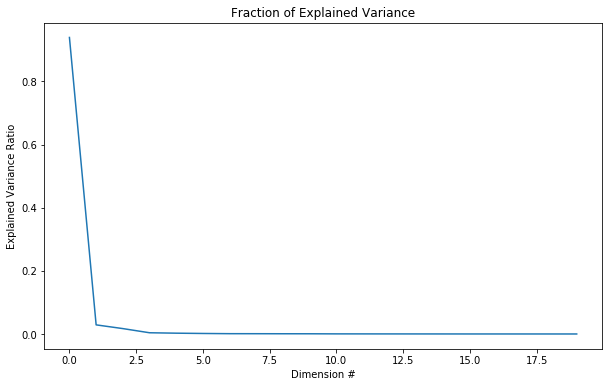

In [140]:
naive_var = plot_naive_variance(pca_naive)

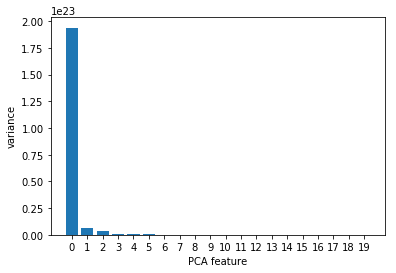

In [141]:
features = range(pca_naive.n_components_)
plt.bar(features, pca_naive.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

### Standardized data

In [142]:
def standardize(df):
    stscaler = StandardScaler().fit(df)
    scaled = stscaler.transform(df)    
    return scaled

In [143]:
scaled = standardize(pca_data)

In [144]:
pca = fit_pca(scaled, n_components=20)

In [145]:
def plot_scaled_variance(pca):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_xlabel('Dimension #')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Fraction of Explained Variance')
    ax.plot(pca.explained_variance_ratio_)
       
    return ax

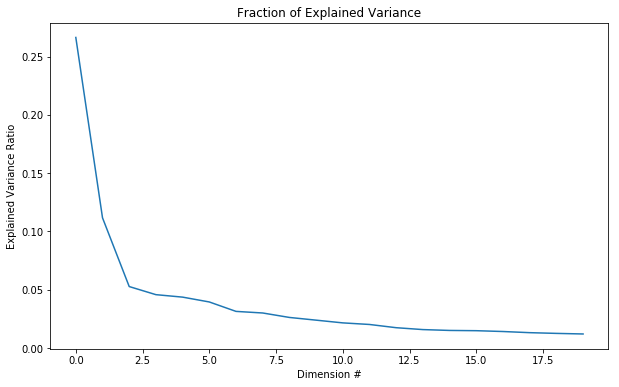

In [146]:
ax = plot_scaled_variance(pca)

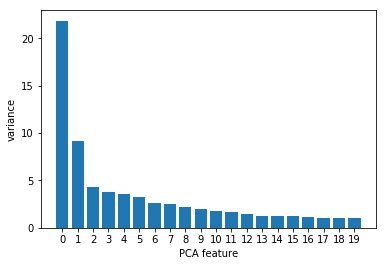

In [147]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [148]:
n_components

NameError: name 'n_components' is not defined

In [149]:
vars = pca.explained_variance_ratio_
c_names = ['f1','f2','f3','f4']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
26.6%:     0.18 * f1 +  0.02 * f2 +  0.06 * f3 + -0.01 * f4
11.2%:    -0.11 * f1 + -0.04 * f2 +  0.09 * f3 + -0.00 * f4
 5.3%:    -0.02 * f1 +  0.16 * f2 + -0.01 * f3 +  0.07 * f4
 4.6%:     0.00 * f1 +  0.17 * f2 + -0.05 * f3 + -0.09 * f4
 4.4%:     0.04 * f1 + -0.05 * f2 + -0.07 * f3 + -0.01 * f4
 4.0%:     0.02 * f1 +  0.16 * f2 +  0.15 * f3 +  0.02 * f4
 3.1%:     0.12 * f1 + -0.10 * f2 +  0.03 * f3 +  0.06 * f4
 3.0%:    -0.00 * f1 + -0.08 * f2 + -0.15 * f3 + -0.19 * f4
 2.6%:     0.11 * f1 + -0.14 * f2 + -0.07 * f3 +  0.10 * f4
 2.4%:    -0.00 * f1 + -0.03 * f2 + -0.12 * f3 +  0.58 * f4
 2.2%:    -0.03 * f1 +  0.09 * f2 +  0.04 * f3 +  0.30 * f4
 2.0%:     0.05 * f1 +  0.27 * f2 + -0.16 * f3 + -0.02 * f4
 1.7%:    -0.11 * f1 + -0.10 * f2 +  0.07 * f3 +  0.04 * f4
 1.6%:    -0.07 * f1 + -0.07 * f2 + -0.12 * f3 + -0.05 * f4
 1.5%:     0.04 * f1 + -0.12 * f2 + -0.02 * f3 + -0.00 * f4
 1.5%:    -0.01 * f1 + -0.10 * f2 +  0

In [150]:
# 82.7% are explained by PCA 20 features
26.6 + 11.2 + 5.3 + 4.6 + 4.4 + 4.0 + 3.1 + 3.0 + 2.4 + 2.4 + 2.2 + 2.0 + 1.7 + 1.6 + 1.5 + 1.5 +1.4 +1.3 + 1.3 + 1.2

82.7

In [151]:
reduced = pca.transform(scaled)

In [152]:
scaled.shape

(1357, 82)

In [153]:
reduced.shape

(1357, 20)

In [154]:
# Troy, please use "reduced" to run clustering. 
# Feel free to edit the PCA part, we can drop more columns when create "pca_data".

In [155]:
reduced

array([[-1.56278518, -0.73125606,  0.97992438, ..., -1.32466395,
        -1.4841203 ,  0.1376714 ],
       [-0.97675834, -0.51000501,  1.41343899, ..., -0.93903114,
        -1.11075746,  0.58435206],
       [ 1.51319683,  1.09890993,  0.34921145, ..., -0.76898119,
        -1.25382602,  0.56650834],
       ...,
       [-1.89060803, -0.18789022, -0.09749051, ...,  0.69035123,
         0.60122572, -0.62129715],
       [-1.87158422, -0.23230812,  0.20607493, ...,  0.98578205,
         0.90233871, -0.38296888],
       [-1.80912161, -0.22620562, -0.08895259, ...,  1.33926633,
         1.36724336, -0.12311141]])

# Clustering

In [156]:
data00=new_data2.copy()

In [157]:
data2012=data00.loc[data00['For Year'] == '2012']
data2013=data00.loc[data00['For Year'] == '2013']
data2014=data00.loc[data00['For Year'] == '2014']
data2015=data00.loc[data00['For Year'] == '2015']
data2016=data00.loc[data00['For Year'] == '2016']

In [158]:
names2012 = data2012['symbol'].values.tolist()
from collections import OrderedDict
names2012 = list(OrderedDict.fromkeys(names2012))

names2013 = data2013['symbol'].values.tolist()
names2013 = list(OrderedDict.fromkeys(names2013))

names2014 = data2014['symbol'].values.tolist()
names2014 = list(OrderedDict.fromkeys(names2014))

names2015 = data2015['symbol'].values.tolist()
names2015 = list(OrderedDict.fromkeys(names2015))

names2016 = data2016['symbol'].values.tolist()
names2016 = list(OrderedDict.fromkeys(names2016))

In [159]:
data2012 = data2012.drop(['symbol', 'date','For Year'], axis=1)
data2013 = data2013.drop(['symbol', 'date','For Year'], axis=1)
data2014 = data2014.drop(['symbol', 'date','For Year'], axis=1)
data2015 = data2015.drop(['symbol', 'date','For Year'], axis=1)
data2016 = data2016.drop(['symbol', 'date','For Year'], axis=1)

In [160]:
#data2012.iloc[:,0:83]

## t-SNE before PCA:

### t-SNE for 2012 before PCA

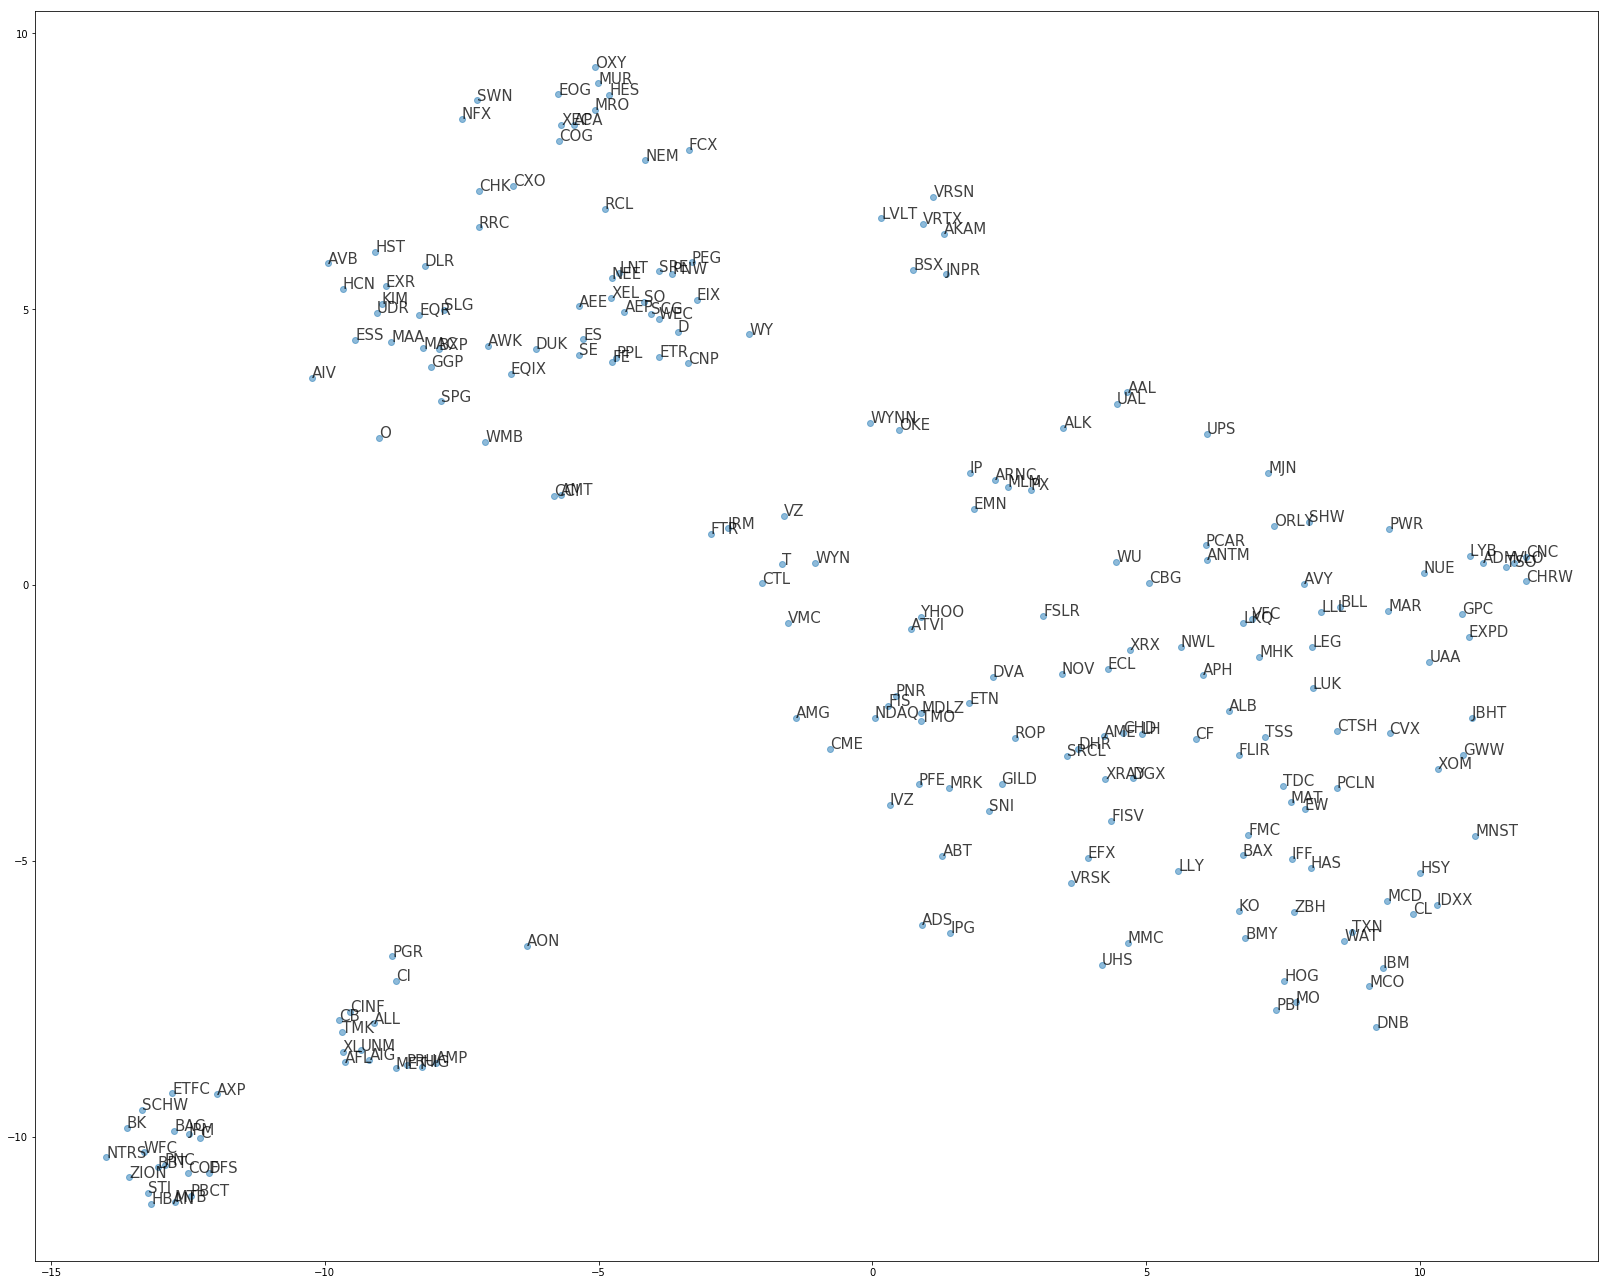

In [68]:
from sklearn.preprocessing import normalize

data2012s = data2012.values
normalized_2012 = normalize(data2012s)

from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2012)

# Select the 0th feature: xs
xs2012 = tsne_features[:,0]

# Select the 1th feature: ys
ys2012 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2012, ys2012, alpha=0.5)
# Annotate the points
for x0, y0, company in zip(xs2012, ys2012, names2012):
    plt.annotate(company, (x0, y0), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

### t-SNE for 2013 before PCA

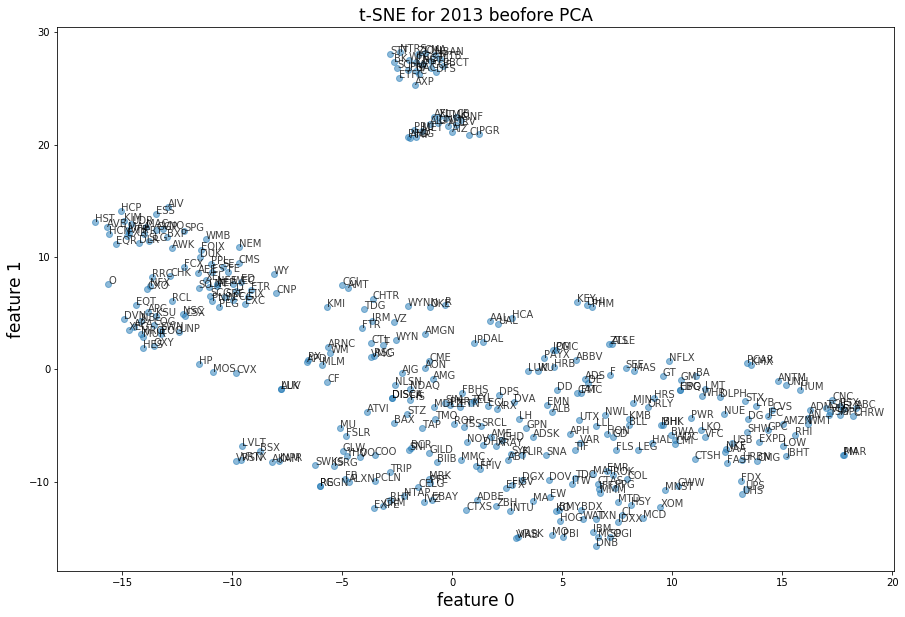

In [84]:
from sklearn.preprocessing import normalize

data2013s = data2013.values
normalized_2013 = normalize(data2013s)

from sklearn.manifold import TSNE

plt.figure(figsize=(15,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2013)

# Select the 0th feature: xs
xs2013 = tsne_features[:,0]

# Select the 1th feature: ys
ys2013 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2013, ys2013, alpha=0.5)
# Annotate the points
for x1, y1, company in zip(xs2013, ys2013, names2013):
    plt.annotate(company, (x1, y1), fontsize=10, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2013 beofore PCA',fontsize=17)
plt.xlabel('feature 0',fontsize=17)
plt.ylabel('feature 1',fontsize=17)
plt.show()


### t-SNE for 2014 before PCA

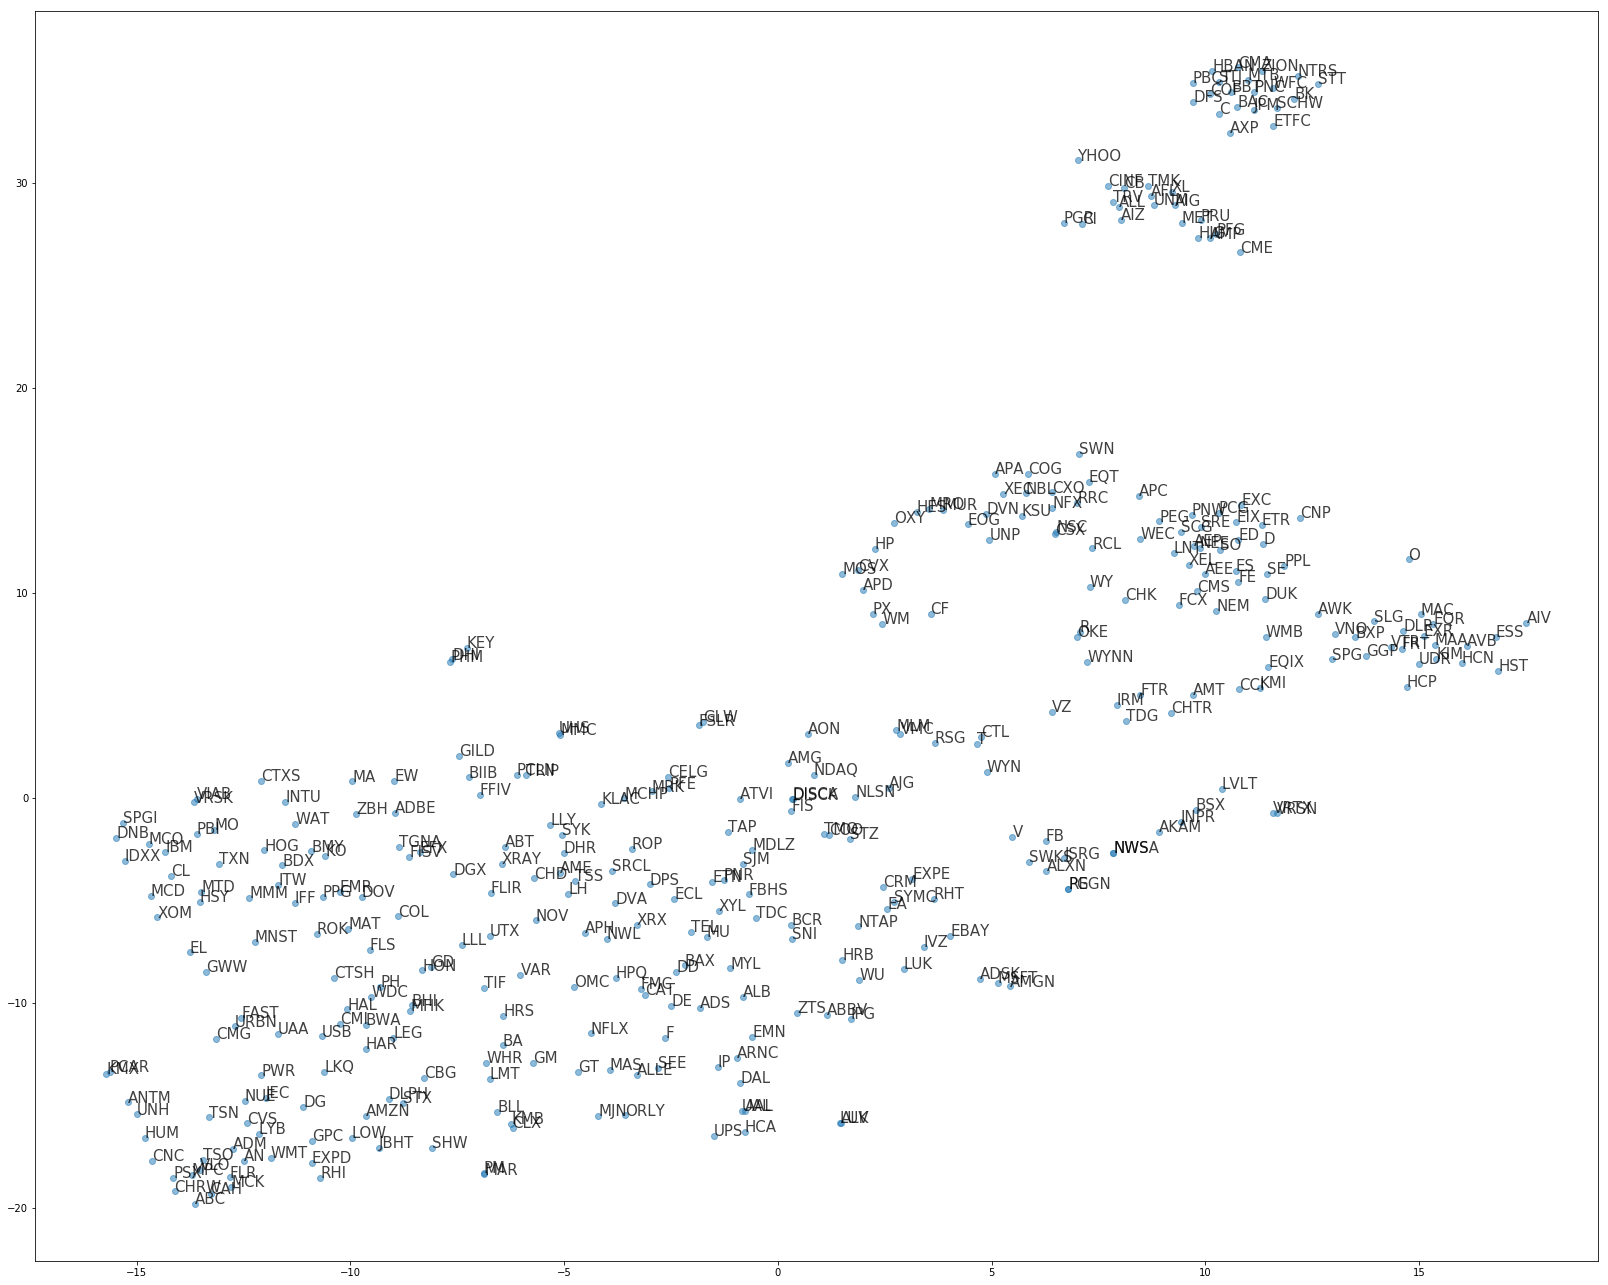

In [59]:
from sklearn.preprocessing import normalize

data2014s = data2014.values
normalized_2014 = normalize(data2014s)

from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2014)

# Select the 0th feature: xs
xs2014 = tsne_features[:,0]

# Select the 1th feature: ys
ys2014 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2014, ys2014, alpha=0.5)
# Annotate the points
for x2, y2, company in zip(xs2014, ys2014, names2014):
    plt.annotate(company, (x2, y2), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

### t-SNE for 2015 before PCA

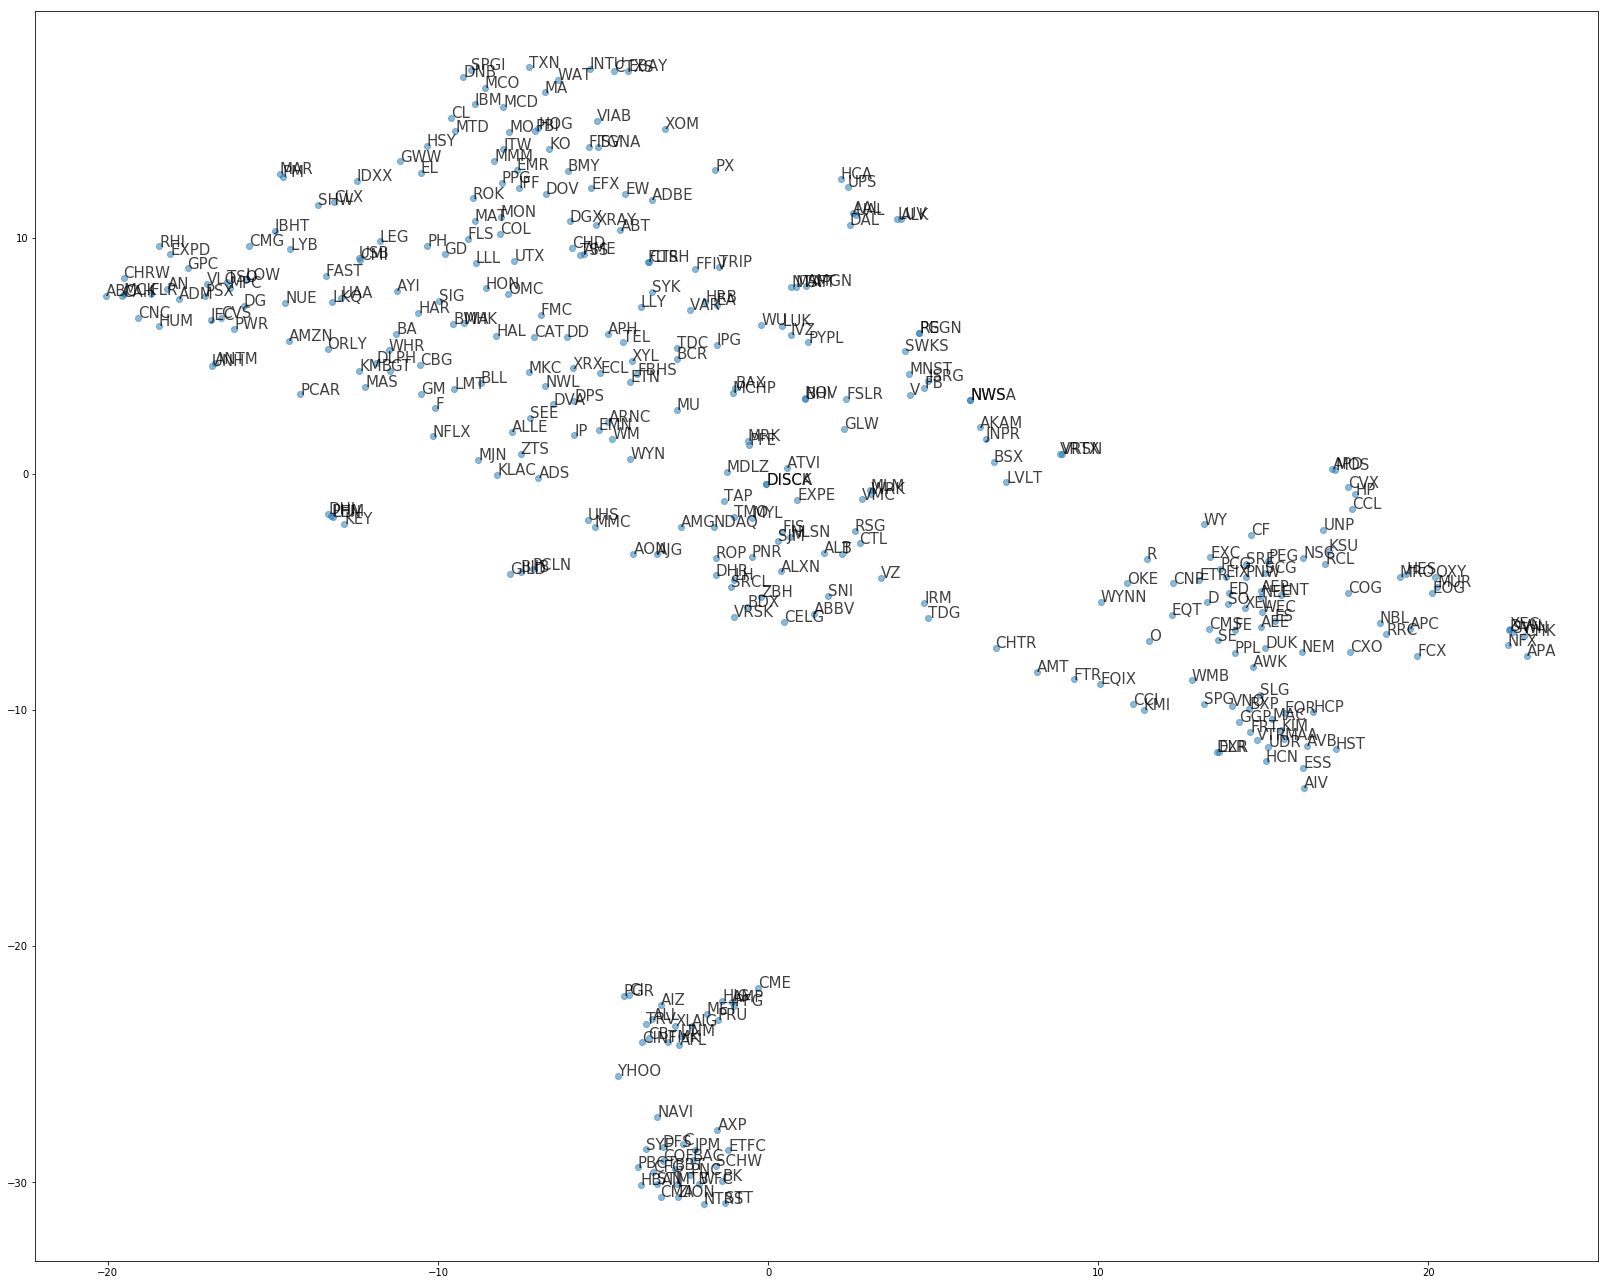

In [60]:
from sklearn.preprocessing import normalize

data2015s = data2015.values
normalized_2015 = normalize(data2015s)

from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2015)

# Select the 0th feature: xs
xs2015 = tsne_features[:,0]

# Select the 1th feature: ys
ys2015 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2015, ys2015, alpha=0.5)
# Annotate the points
for x3, y3, company in zip(xs2015, ys2015, names2015):
    plt.annotate(company, (x3, y3), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

### t-SNE for 2016 before PCA

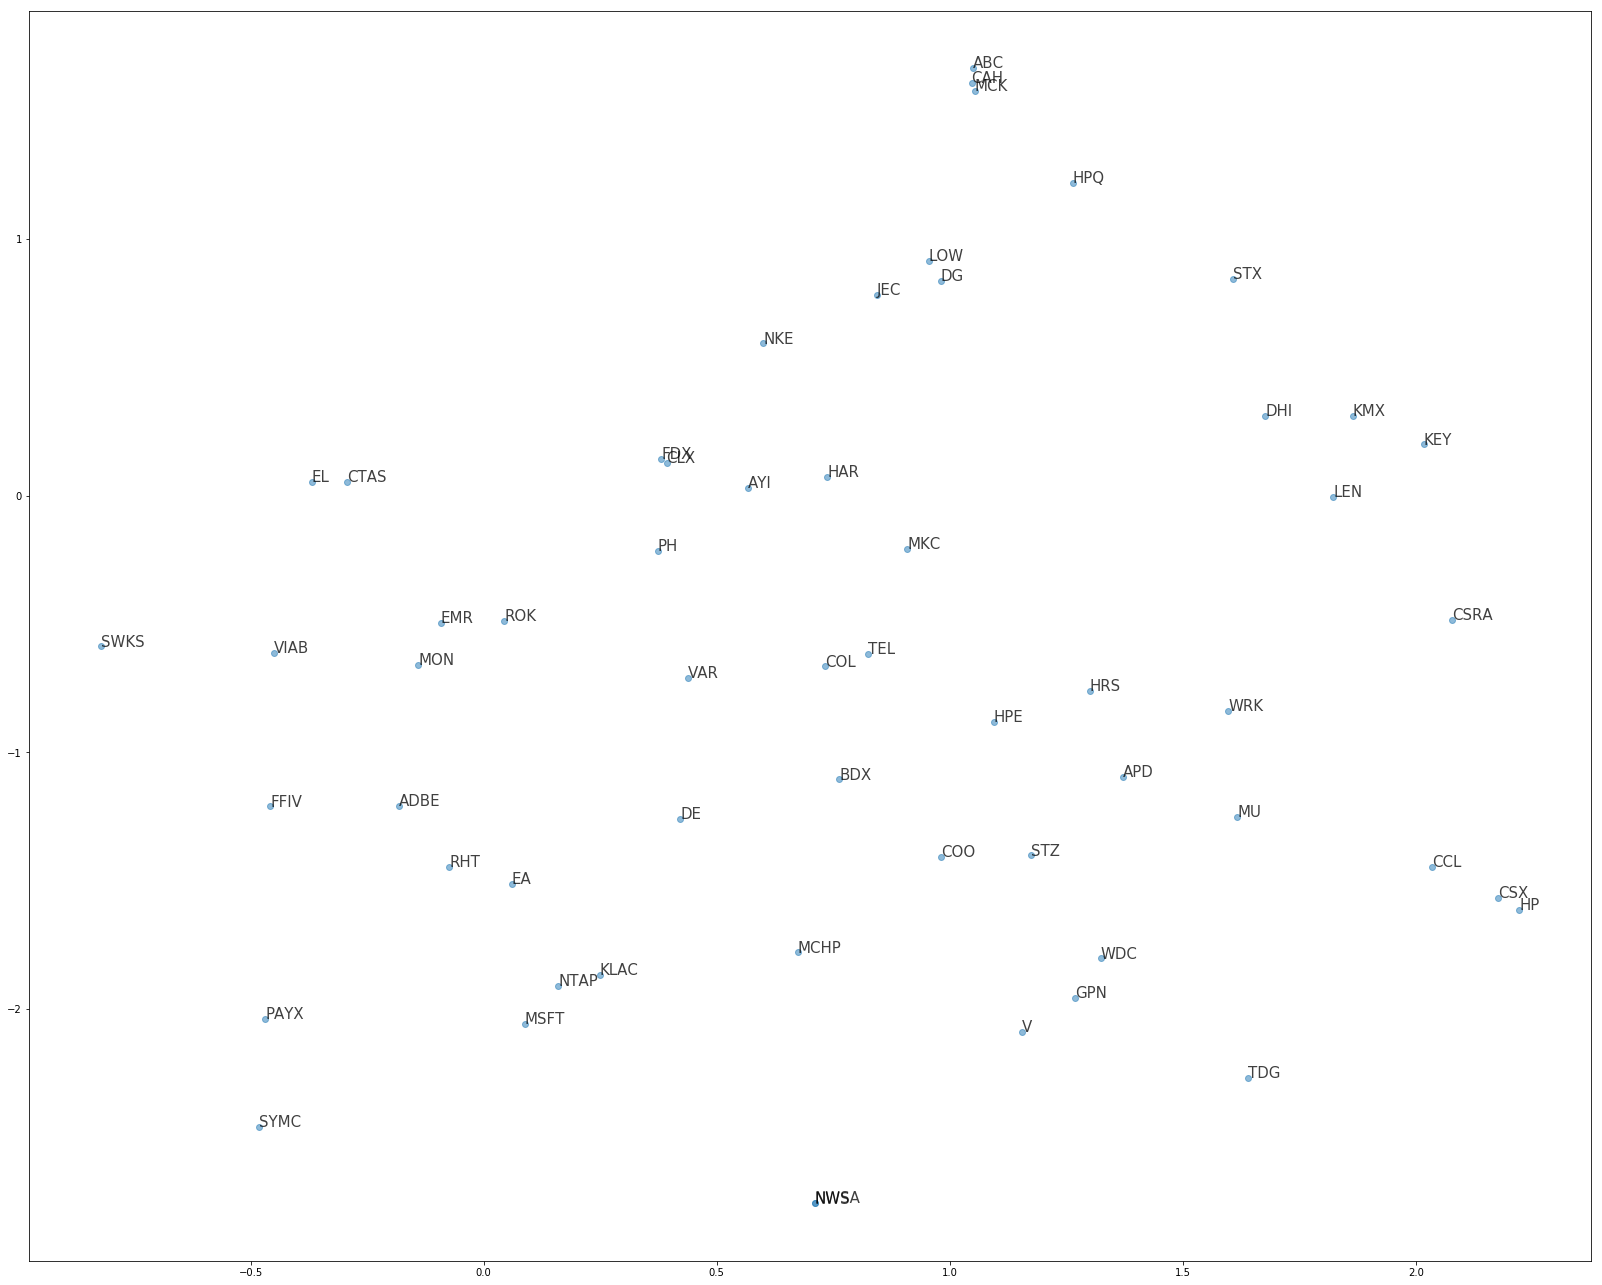

In [61]:
from sklearn.preprocessing import normalize

data2016s = data2016.values
normalized_2016 = normalize(data2016s)

from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50,perplexity=40)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2016)

# Select the 0th feature: xs
xs2016 = tsne_features[:,0]

# Select the 1th feature: ys
ys2016 = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2016, ys2016, alpha=0.5)
# Annotate the points
for x4, y4, company in zip(xs2016, ys2016, names2016):
    plt.annotate(company, (x4, y4), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

## t-SNE after PCA:

In [86]:
df00=new_data2.copy()

In [87]:
df11 = pd.DataFrame(data=reduced)
#x21 = df11.iloc[:,0:19].values
df11['Year'] = df00['For Year']
df11['symbol']=df00['symbol']
#df11

In [88]:
pca2012=df11.loc[df11['Year'] == '2012']
pca2013=df11.loc[df11['Year'] == '2013']
pca2014=df11.loc[df11['Year'] == '2014']
pca2015=df11.loc[df11['Year'] == '2015']
pca2016=df11.loc[df11['Year'] == '2016']

In [89]:
pcaname2012 = pca2012['symbol'].values.tolist()
from collections import OrderedDict
pcaname2012 = list(OrderedDict.fromkeys(pcaname2012))

pcaname2013 = pca2013['symbol'].values.tolist()
pcaname2013 = list(OrderedDict.fromkeys(pcaname2013))

pcaname2014 = pca2014['symbol'].values.tolist()
pcaname2014 = list(OrderedDict.fromkeys(pcaname2014))

pcaname2015 = pca2015['symbol'].values.tolist()
pcaname2015 = list(OrderedDict.fromkeys(pcaname2015))

pcaname2016 = pca2016['symbol'].values.tolist()
pcaname2016 = list(OrderedDict.fromkeys(pcaname2016))

pca2012 = pca2012.drop(['symbol','Year'], axis=1)
pca2013 = pca2013.drop(['symbol','Year'], axis=1)
pca2014 = pca2014.drop(['symbol','Year'], axis=1)
pca2015 = pca2015.drop(['symbol','Year'], axis=1)
pca2016 = pca2016.drop(['symbol','Year'], axis=1)
#pcaname2012

### t-SNE for 2012 after PCA

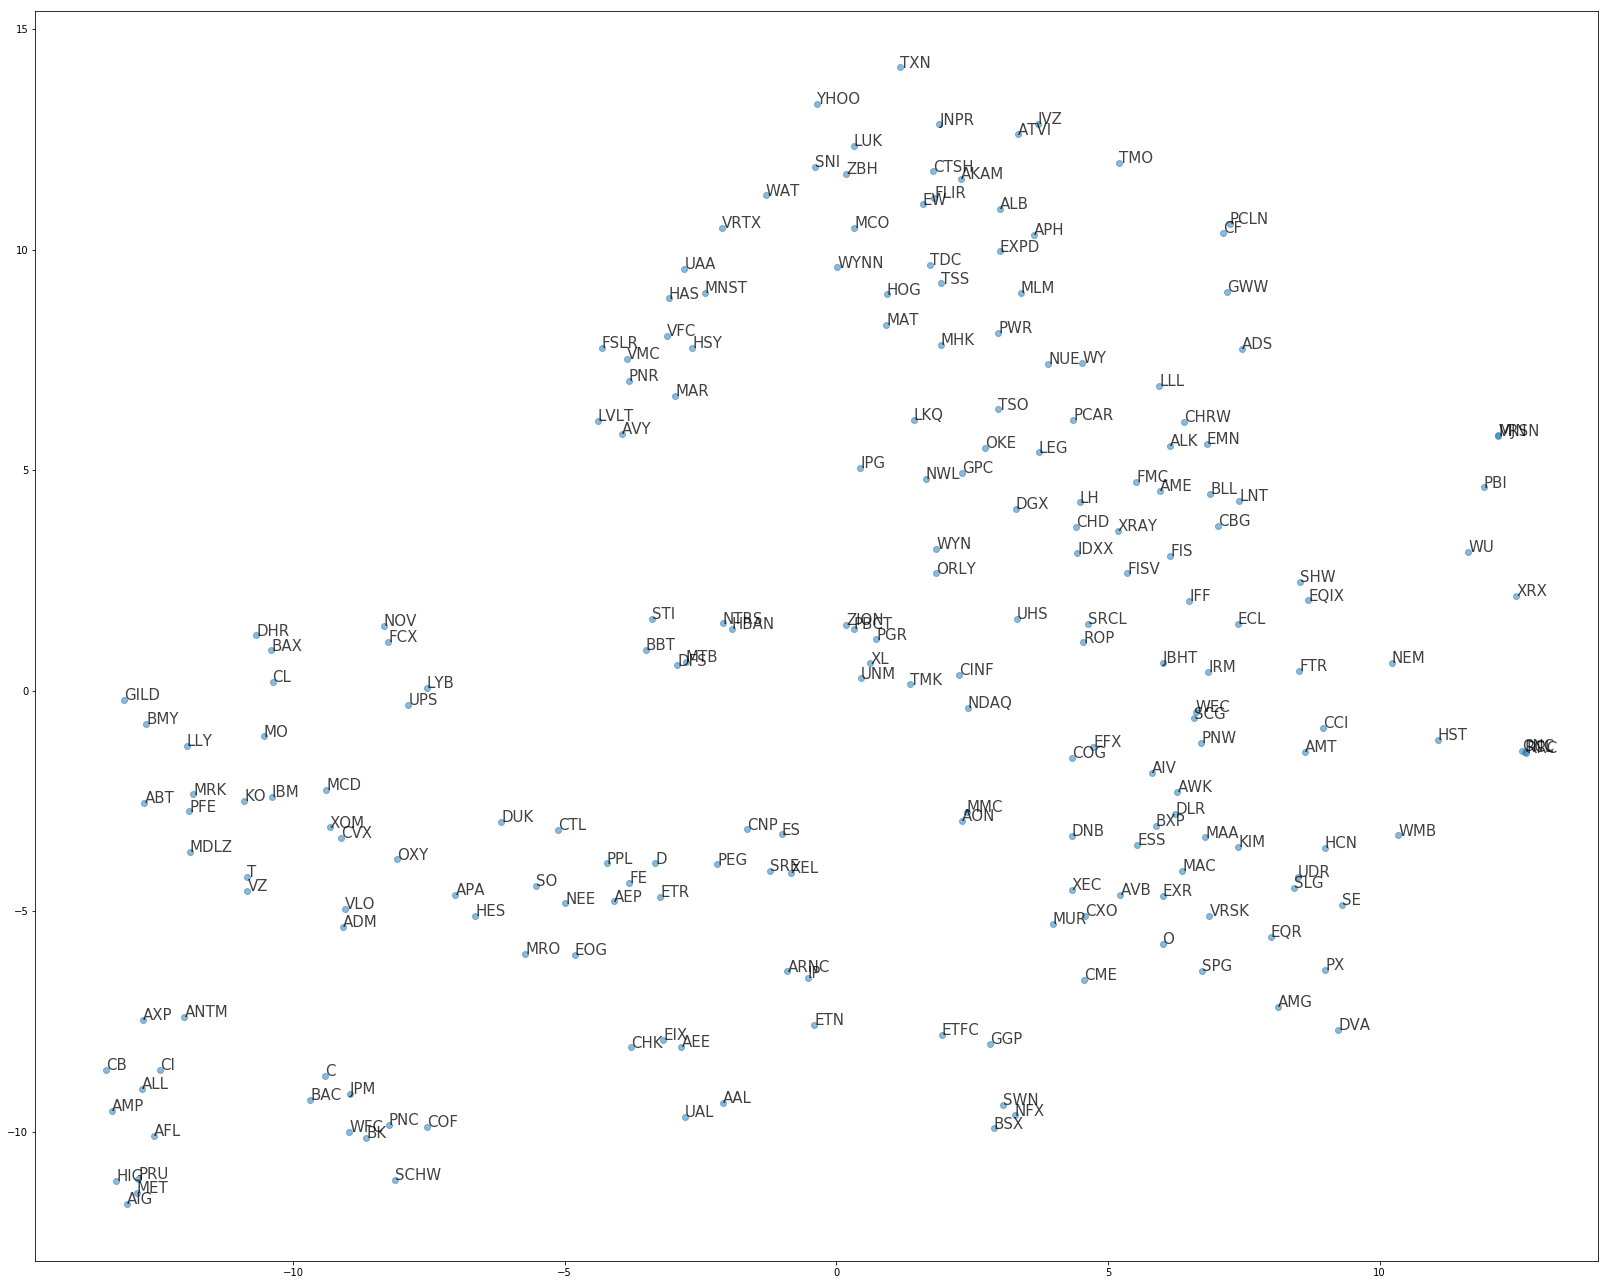

In [90]:
from sklearn.preprocessing import normalize

pca2012s = pca2012.values
normalized_2012pca = normalize(pca2012s)

from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2012pca)

# Select the 0th feature: xs
xs2012pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2012pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2012pca, ys2012pca, alpha=0.5)
# Annotate the points
for x00, y00, company in zip(xs2012pca, ys2012pca, pcaname2012):
    plt.annotate(company, (x00, y00), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

### t-SNE for 2013 after PCA

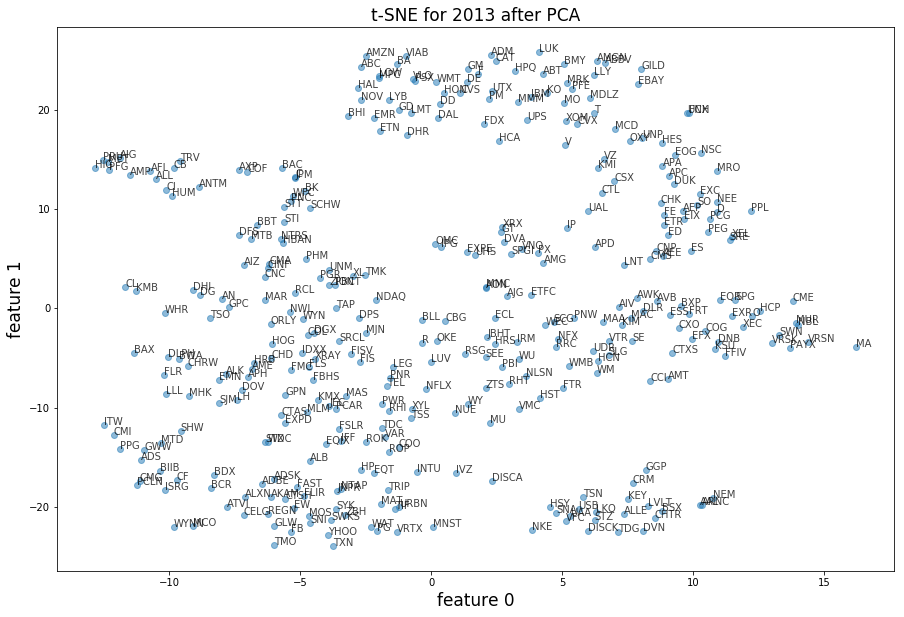

In [93]:
pca2013s = pca2013.values
normalized_2013pca = normalize(pca2013s)

plt.figure(figsize=(15,10))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2013pca)

# Select the 0th feature: xs
xs2013pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2013pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2013pca, ys2013pca, alpha=0.5)
# Annotate the points
for x11, y11, company in zip(xs2013pca, ys2013pca, pcaname2013):
    plt.annotate(company, (x11, y11), fontsize=10, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.title('t-SNE for 2013 after PCA',fontsize=17)
plt.xlabel('feature 0',fontsize=17)
plt.ylabel('feature 1',fontsize=17)
plt.show()


### t-SNE for 2014 after PCA

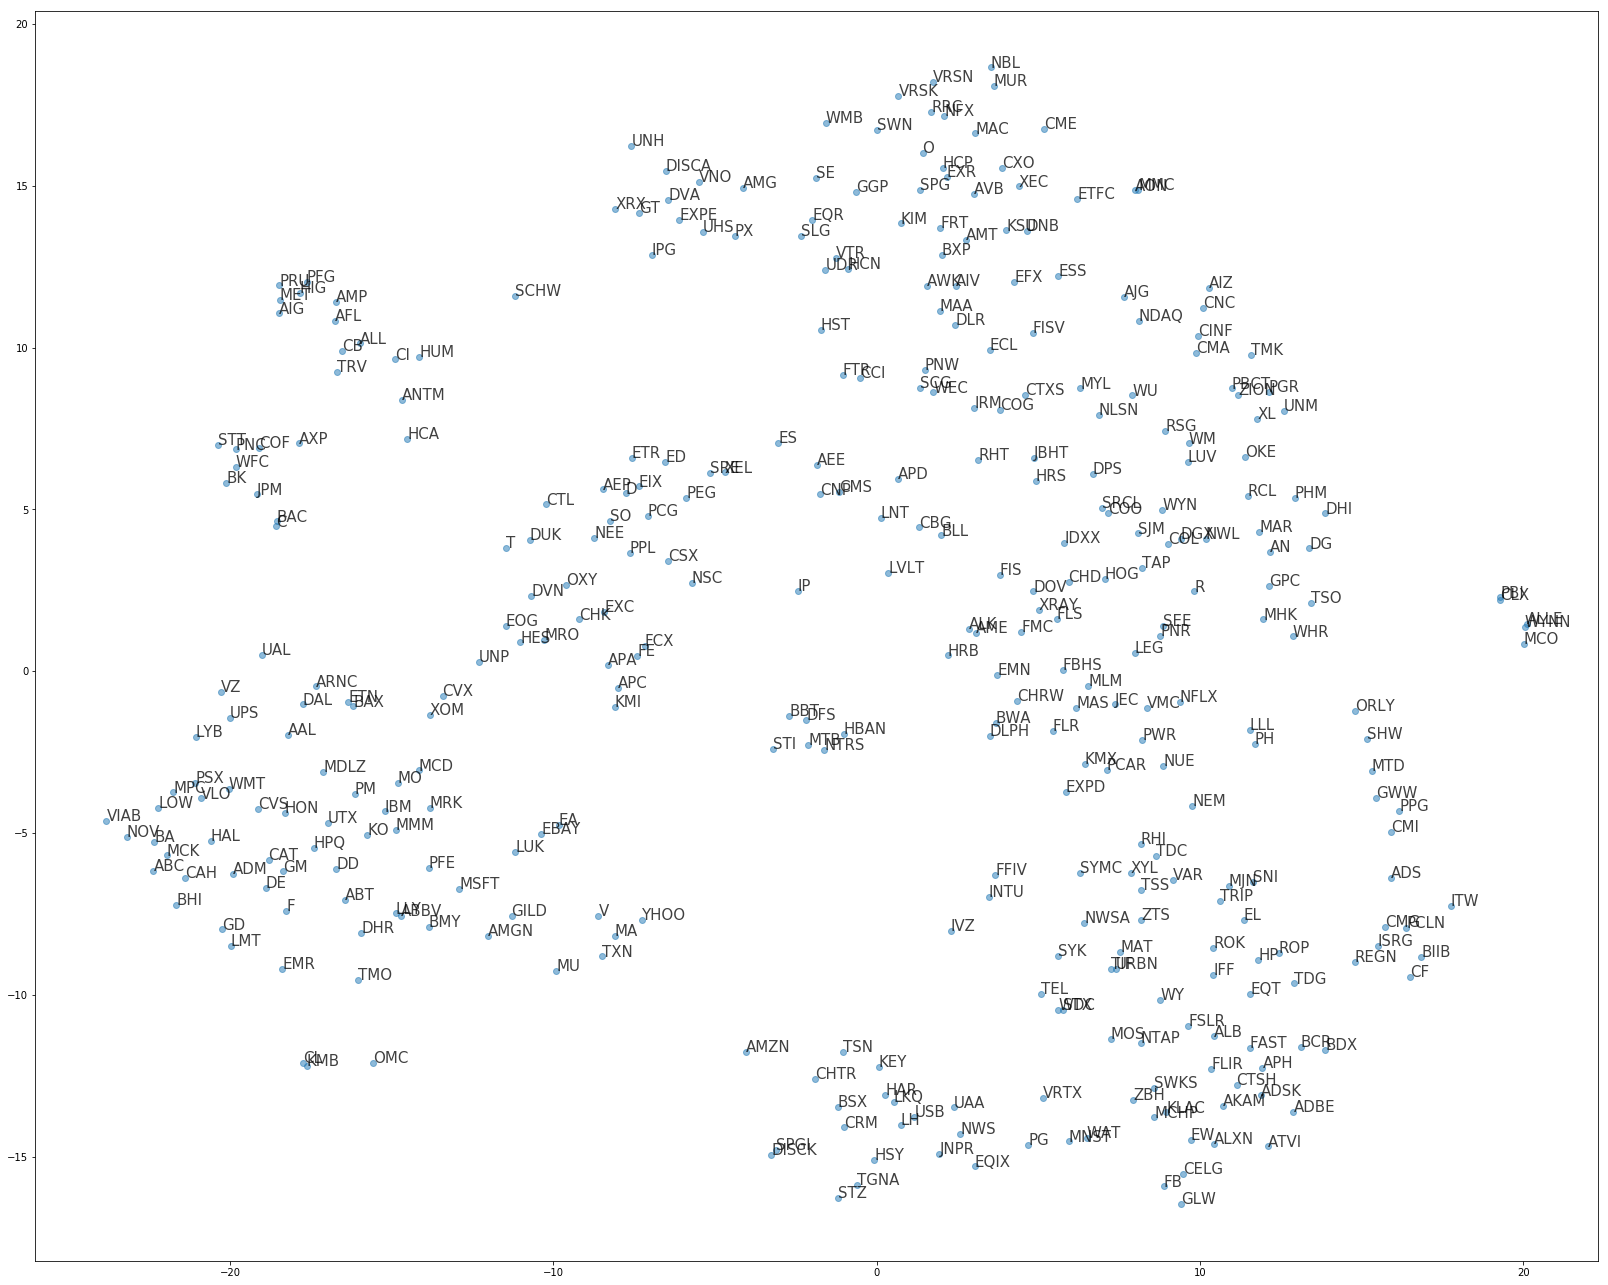

In [92]:
pca2014s = pca2014.values
normalized_2014pca = normalize(pca2014s)

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2014pca)

# Select the 0th feature: xs
xs2014pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2014pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2014pca, ys2014pca, alpha=0.5)
# Annotate the points
for x22, y22, company in zip(xs2014pca, ys2014pca, pcaname2014):
    plt.annotate(company, (x22, y22), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

### t-SNE for 2015 after PCA

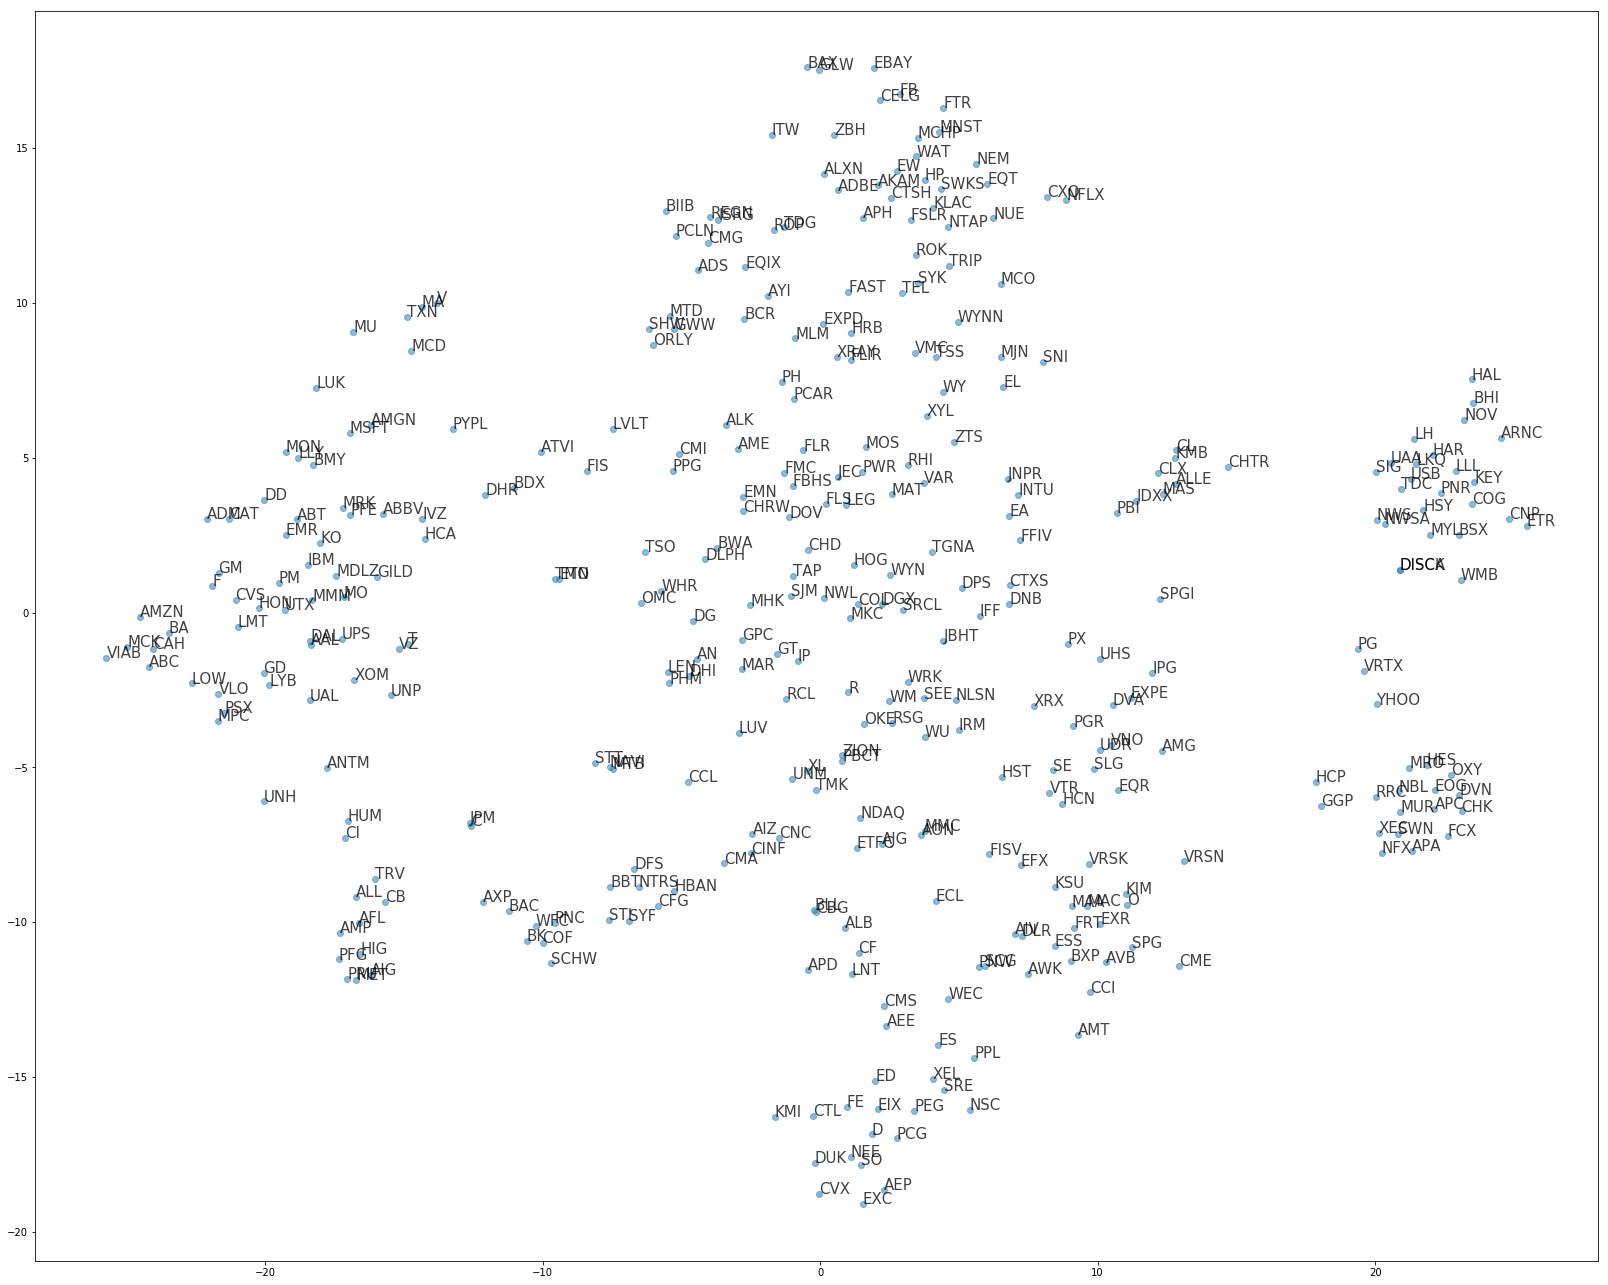

In [94]:
pca2015s = pca2015.values
normalized_2015pca = normalize(pca2015s)

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2015pca)

# Select the 0th feature: xs
xs2015pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2015pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2015pca, ys2015pca, alpha=0.5)
# Annotate the points
for x33, y33, company in zip(xs2015pca, ys2015pca, pcaname2015):
    plt.annotate(company, (x33, y33), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

### t-SNE for 2016 after PCA

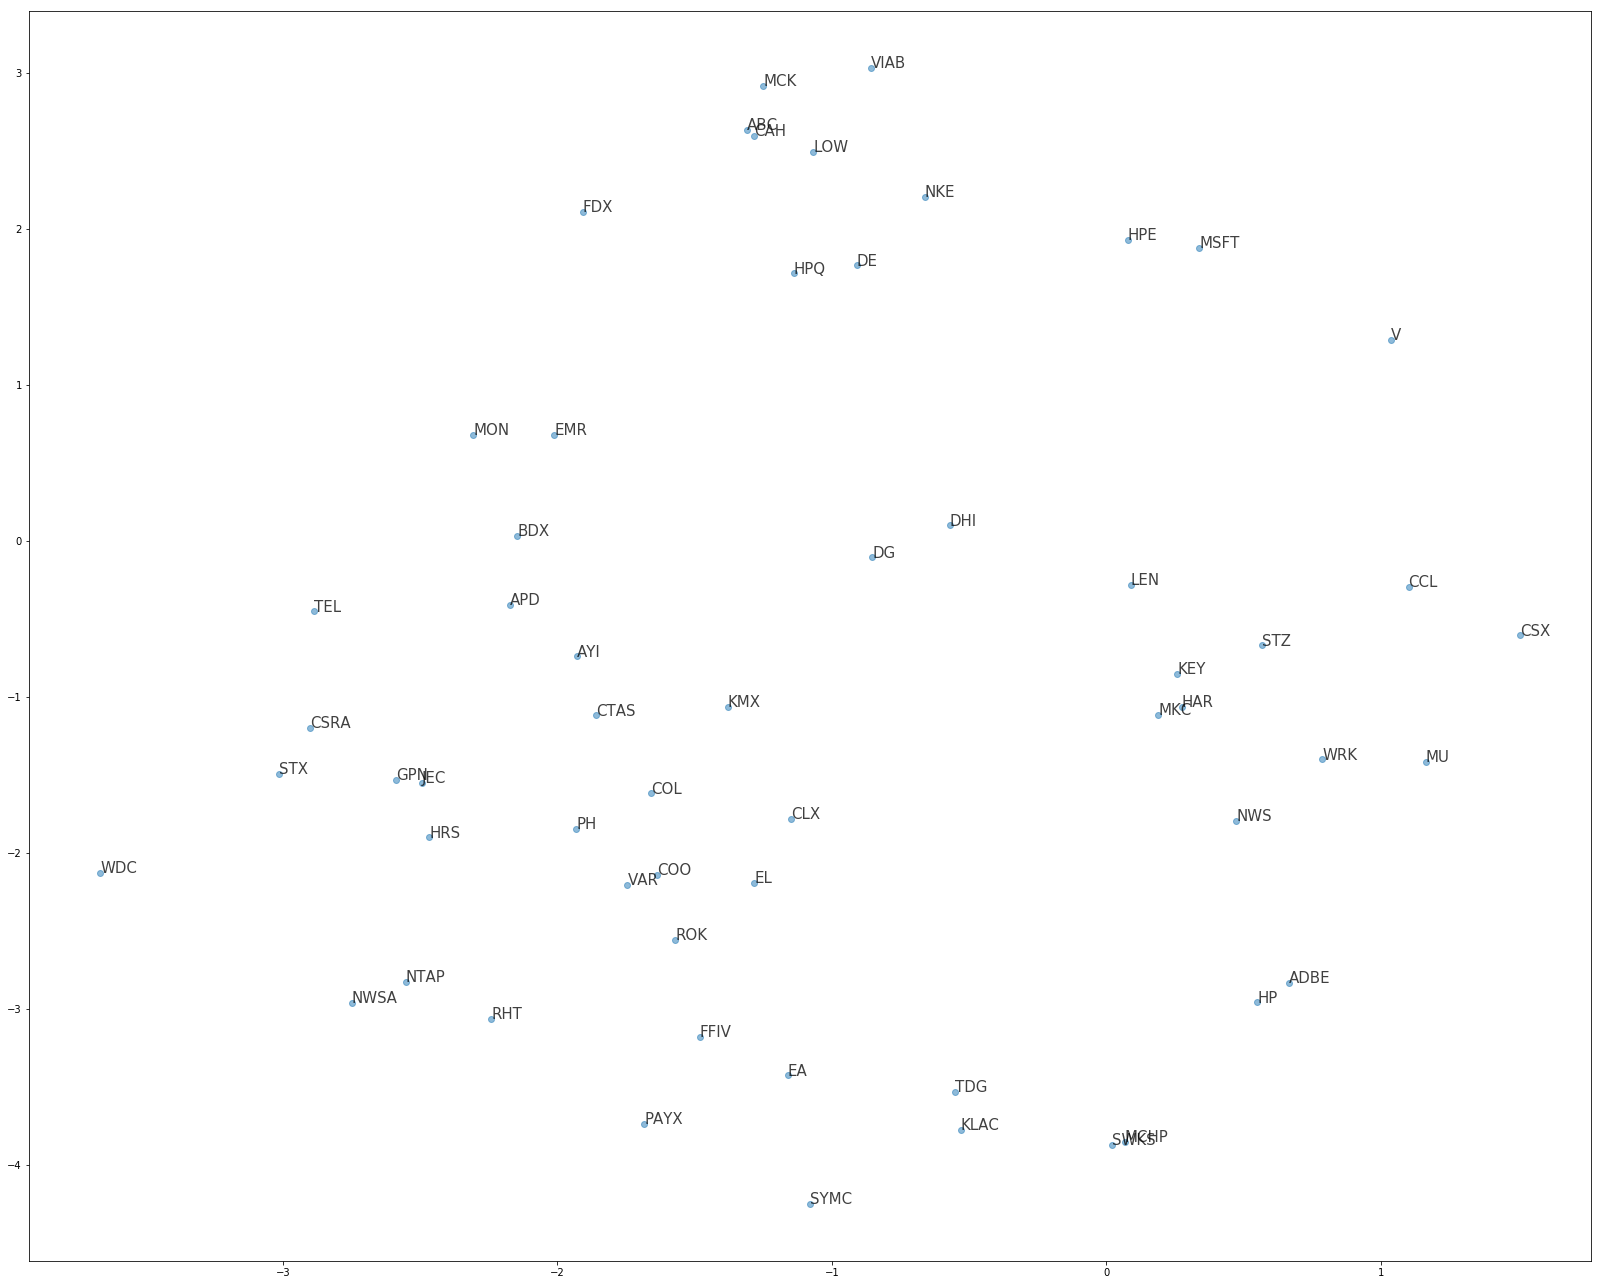

In [94]:
pca2016s = pca2016.values
normalized_2016pca = normalize(pca2016s)

plt.figure(figsize=(28,23))


# Create a TSNE instance: model
model = TSNE(learning_rate=50)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_2016pca)

# Select the 0th feature: xs
xs2016pca = tsne_features[:,0]

# Select the 1th feature: ys
ys2016pca = tsne_features[:,1]

# Scatter plot
plt.scatter(xs2016pca, ys2016pca, alpha=0.5)
# Annotate the points
for x44, y44, company in zip(xs2016pca, ys2016pca, pcaname2016):
    plt.annotate(company, (x44, y44), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()

## K-means before PCA

In [155]:
#data2012.iloc[:,0:84]

### K-means for 2012 before PCA

In [220]:
#import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

x2012 = data2012.iloc[:,0:83].values

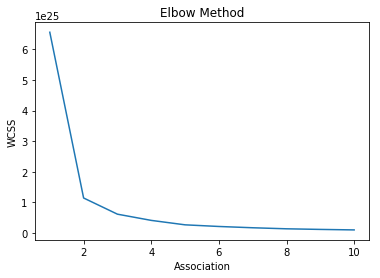

In [221]:
#Let's select the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2012)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

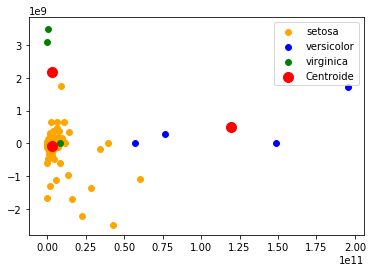

In [222]:
#k = 3
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2012 = kmeans.fit_predict(x2012)

plt.scatter(x2012[y_kmeans2012 == 0, 0], x2012[y_kmeans2012 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x2012[y_kmeans2012 == 1, 0], x2012[y_kmeans2012 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
plt.scatter(x2012[y_kmeans2012 == 2, 0], x2012[y_kmeans2012 == 2, 1], s = 35, 
            c = 'green', label = 'virginica')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'orange', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

### K-means for 2013 before PCA

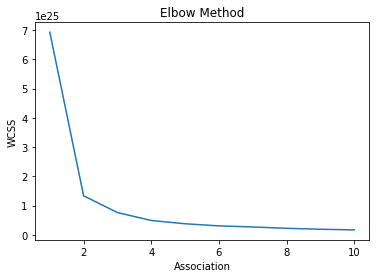

In [223]:
x2013 = data2013.iloc[:,0:83].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2013)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

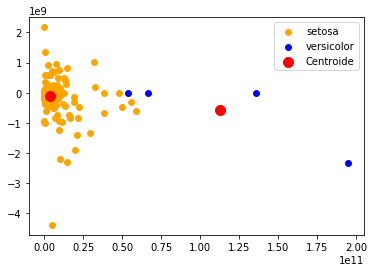

In [224]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2013 = kmeans.fit_predict(x2013)

plt.scatter(x2013[y_kmeans2013 == 0, 0], x2013[y_kmeans2013 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x2013[y_kmeans2013 == 1, 0], x2013[y_kmeans2013 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
#plt.scatter(x2013[y_kmeans2013 == 2, 0], x2013[y_kmeans2013 == 2, 1], s = 35, 
#            c = 'green', label = 'virginica')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'orange', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

### K-means for 2014 before PCA

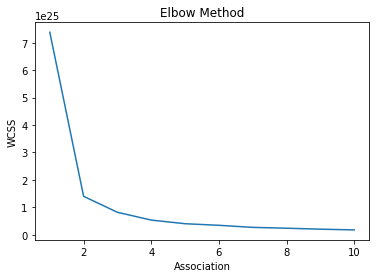

In [225]:
x2014 = data2014.iloc[:,0:83].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2014)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

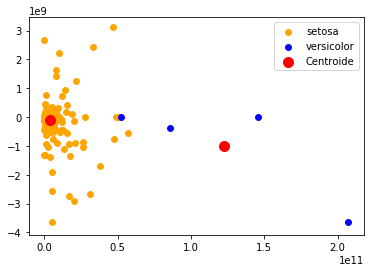

In [226]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2014 = kmeans.fit_predict(x2014)

plt.scatter(x2014[y_kmeans2014 == 0, 0], x2014[y_kmeans2014 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x2014[y_kmeans2014 == 1, 0], x2014[y_kmeans2014 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
#plt.scatter(x2013[y_kmeans2013 == 2, 0], x2013[y_kmeans2013 == 2, 1], s = 35, 
#            c = 'green', label = 'virginica')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'orange', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

### K-means for 2015 before PCA

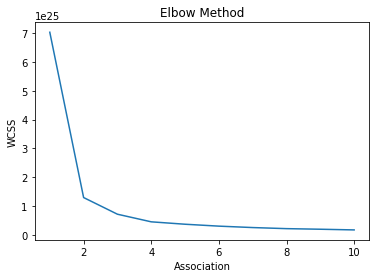

In [227]:
x2015 = data2015.iloc[:,0:83].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2015)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

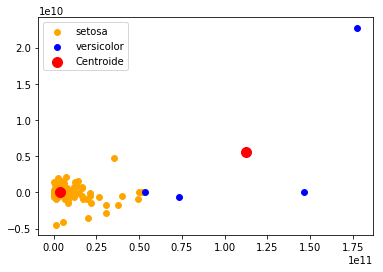

In [228]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2015 = kmeans.fit_predict(x2015)

plt.scatter(x2015[y_kmeans2015 == 0, 0], x2015[y_kmeans2015 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x2015[y_kmeans2015 == 1, 0], x2015[y_kmeans2015 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
#plt.scatter(x2013[y_kmeans2013 == 2, 0], x2013[y_kmeans2013 == 2, 1], s = 35, 
#            c = 'green', label = 'virginica')
#plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 35, 
#            c = 'orange', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

### K-means for 2016 before PCA

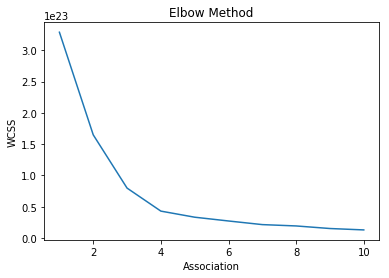

In [229]:
x2016 = data2016.iloc[:,0:83].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(x2016)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

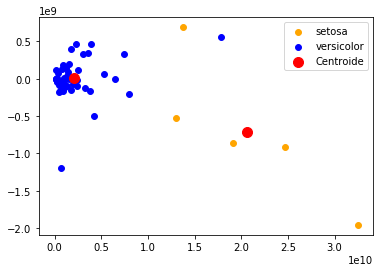

In [230]:
#k = 2
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans2016 = kmeans.fit_predict(x2016)

plt.scatter(x2016[y_kmeans2016 == 0, 0], x2016[y_kmeans2016 == 0, 1], s = 35, 
            c = 'orange', label = 'setosa')
plt.scatter(x2016[y_kmeans2016 == 1, 0], x2016[y_kmeans2016 == 1, 1], s = 35, 
            c = 'blue', label = 'versicolor')
#plt.scatter(x2016[y_kmeans2016 == 2, 0], x2016[y_kmeans2016 == 2, 1], s = 35, 
#            c = 'green', label = 'virginica')
#plt.scatter(x2016[y_kmeans2016 == 3, 0], x2016[y_kmeans2016 == 3, 1], s = 35, 
#            c = 'orange', label = 'black')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 100, 
            c = 'red', label = 'Centroide')

plt.legend()

## K-means after PCA

In [140]:
#pca2012.iloc[:,0:20]

### K-means for 2012 after PCA

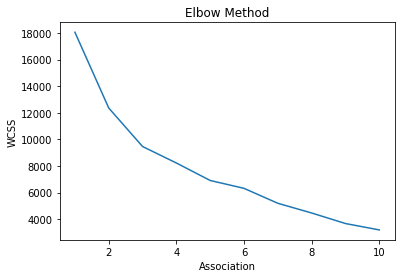

In [141]:
xx2012 = pca2012.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2012)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

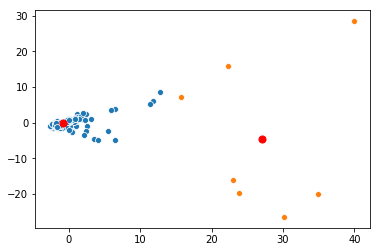

In [142]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans12 = kmeans.fit_predict(xx2012)

for i in range(0,2):
    sns.scatterplot(xx2012[y_kmeans12 == i, 0], xx2012[y_kmeans12 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

### K-means for 2013 after PCA

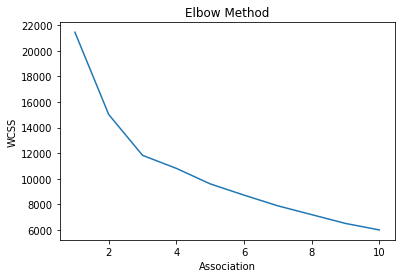

In [143]:
xx2013 = pca2013.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2013)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

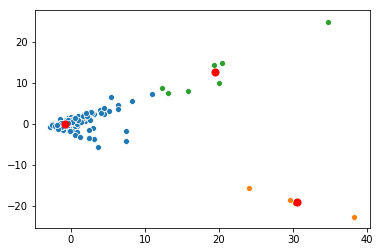

In [144]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans13 = kmeans.fit_predict(xx2013)

for i in range(0,3):
    sns.scatterplot(xx2013[y_kmeans13 == i, 0], xx2013[y_kmeans13 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

### K-means for 2014 after PCA

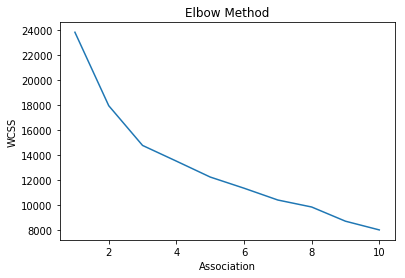

In [145]:
xx2014 = pca2014.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2014)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

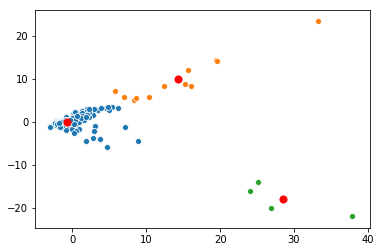

In [146]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans14 = kmeans.fit_predict(xx2014)

for i in range(0,3):
    sns.scatterplot(xx2014[y_kmeans14 == i, 0], xx2014[y_kmeans14 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

### K-means for 2015 after PCA

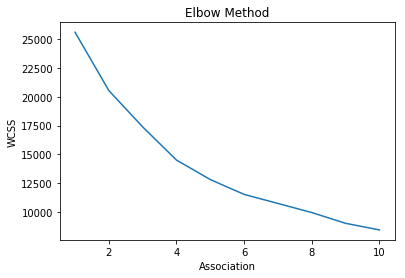

In [147]:
xx2015 = pca2015.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2015)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

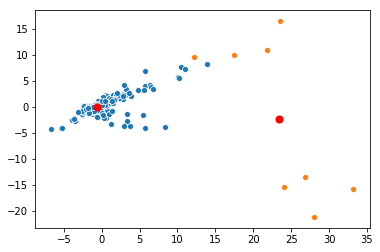

In [148]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans15 = kmeans.fit_predict(xx2015)

for i in range(0,2):
    sns.scatterplot(xx2015[y_kmeans15 == i, 0], xx2015[y_kmeans15 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

### K-means for 2016 after PCA

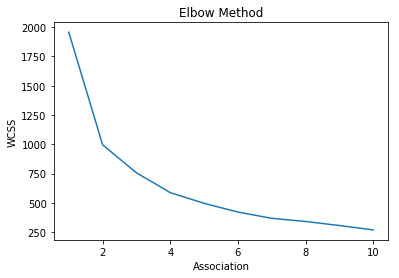

In [149]:
xx2016 = pca2016.iloc[:,0:20].values
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(xx2016)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

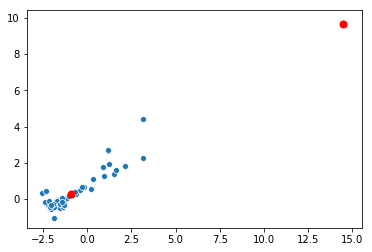

In [150]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 500, 
                n_init = 10, random_state = 0)
y_kmeans16 = kmeans.fit_predict(xx2016)

for i in range(0,2):
    sns.scatterplot(xx2016[y_kmeans16 == i, 0], xx2016[y_kmeans16 == i, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:,1], s = 50, 
            c = 'red')

## DBSCAN before PCA

### DBSCAN for 2012 before PCA

Text(0, 0.5, 'feature 1')

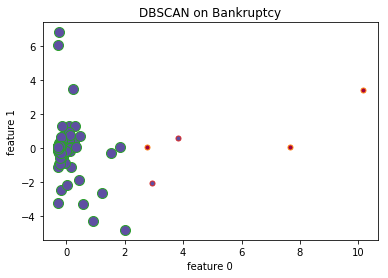

In [231]:
from sklearn.preprocessing import StandardScaler

bp2012 = data2012.iloc[:,0:83].values
stscaler = StandardScaler().fit(bp2012)
st2012 = stscaler.transform(bp2012)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2012)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2012[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2012[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2013 before PCA

Text(0, 0.5, 'feature 1')

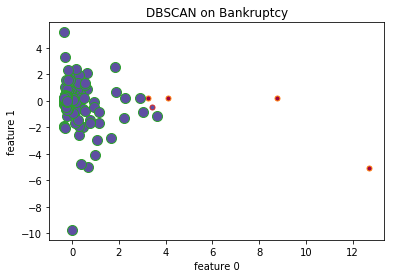

In [232]:
from sklearn.preprocessing import StandardScaler

bp2013 = data2013.iloc[:,0:83].values
stscaler = StandardScaler().fit(bp2013)
st2013 = stscaler.transform(bp2013)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2013)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2013[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2013[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2014 before PCA

Text(0, 0.5, 'feature 1')

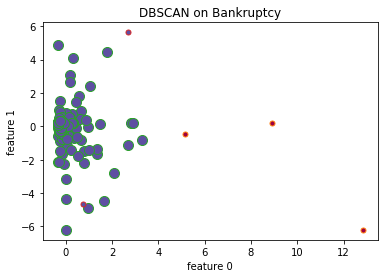

In [233]:
from sklearn.preprocessing import StandardScaler

bp2014 = data2014.iloc[:,0:83].values
stscaler = StandardScaler().fit(bp2014)
st2014 = stscaler.transform(bp2014)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2014)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2014[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2014[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2015 before PCA

Text(0, 0.5, 'feature 1')

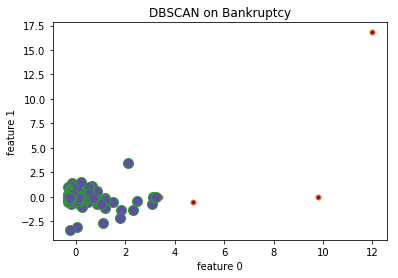

In [234]:
from sklearn.preprocessing import StandardScaler

bp2015 = data2015.iloc[:,0:83].values
stscaler = StandardScaler().fit(bp2015)
st2015 = stscaler.transform(bp2015)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 30.7, min_samples = 5).fit(st2015)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2015[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2015[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2016 before PCA

Text(0, 0.5, 'feature 1')

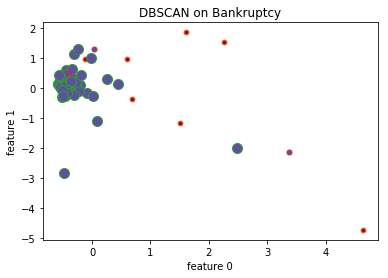

In [262]:
from sklearn.preprocessing import StandardScaler

bp2016 = data2016.iloc[:,0:83].values
stscaler = StandardScaler().fit(bp2016)
st2016 = stscaler.transform(bp2016)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(st2016)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = st2016[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = st2016[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

## DBSCAN after PCA

### DBSCAN for 2012 after PCA

Text(0, 0.5, 'feature 1')

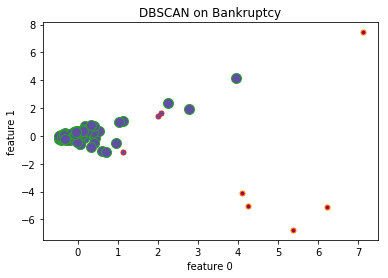

In [252]:
ap2012 = pca2012.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2012)
stp2012 = stscaler.transform(ap2012)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2012)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2012[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2012[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2013 after PCA

Text(0, 0.5, 'feature 1')

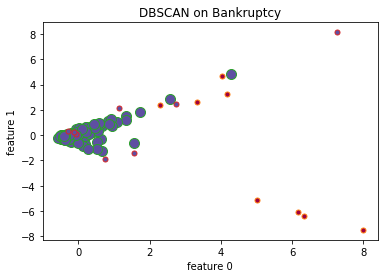

In [253]:
ap2013 = pca2013.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2013)
stp2013 = stscaler.transform(ap2013)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2013)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2013[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2013[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2014 after PCA

Text(0, 0.5, 'feature 1')

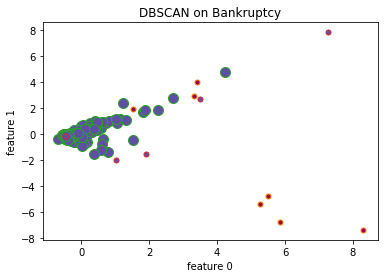

In [254]:
ap2014 = pca2014.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2014)
stp2014 = stscaler.transform(ap2014)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2014)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2014[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2014[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2015 after PCA

Text(0, 0.5, 'feature 1')

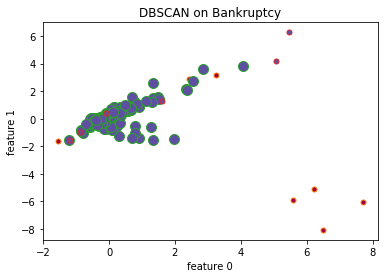

In [255]:
ap2015 = pca2015.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2015)
stp2015 = stscaler.transform(ap2015)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2015)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2015[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2015[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

### DBSCAN for 2016 after PCA

Text(0, 0.5, 'feature 1')

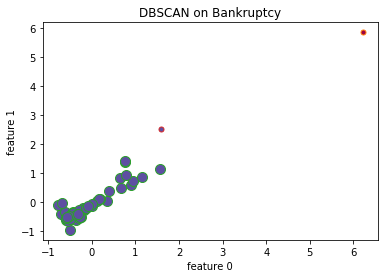

In [256]:
ap2016 = pca2016.iloc[:,0:20].values
stscaler = StandardScaler().fit(ap2016)
stp2016 = stscaler.transform(ap2016)

from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 10.7, min_samples = 20).fit(stp2016)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = stp2016[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = stp2016[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
plt.title("DBSCAN on Bankruptcy")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

## Hierarchical Clustering before PCA

### HC for 2012 before PCA

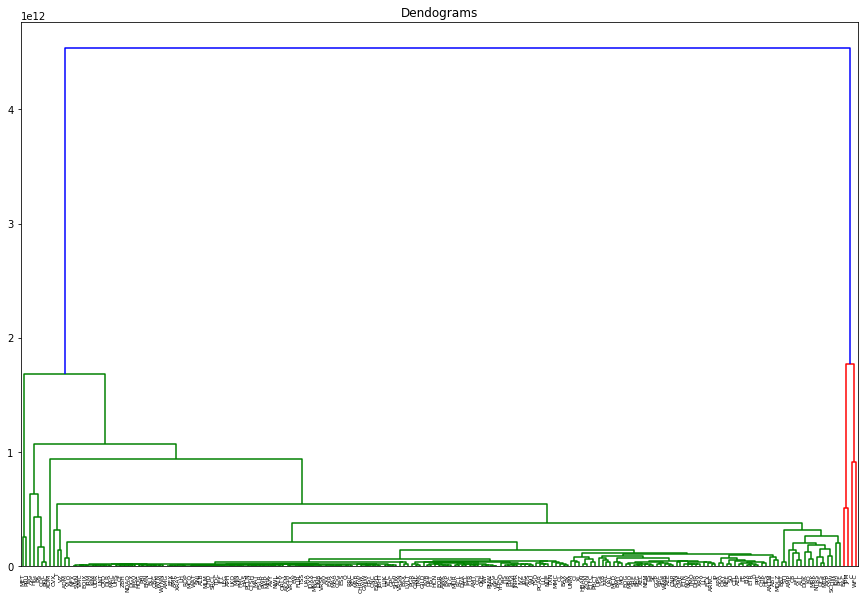

['AAL', 'ABT', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AKAM', 'ALB', 'ALK', 'ALL', 'AME', 'AMG', 'AMP', 'AMT', 'ANTM', 'AON', 'APA', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVY', 'AWK', 'AXP', 'BAC', 'BAX', 'BBT', 'BK', 'BLL', 'BMY', 'BSX', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CF', 'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CME', 'CNC', 'CNP', 'COF', 'COG', 'CTL', 'CTSH', 'CVX', 'CXO', 'D', 'DFS', 'DGX', 'DHR', 'DLR', 'DNB', 'DUK', 'DVA', 'ECL', 'EFX', 'EIX', 'EMN', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'FCX', 'FE', 'FIS', 'FISV', 'FLIR', 'FMC', 'FSLR', 'FTR', 'GGP', 'GILD', 'GPC', 'GWW', 'HAS', 'HBAN', 'HCN', 'HES', 'HIG', 'HOG', 'HST', 'HSY', 'IBM', 'IDXX', 'IFF', 'IP', 'IPG', 'IRM', 'IVZ', 'JBHT', 'JNPR', 'JPM', 'KIM', 'KO', 'LEG', 'LH', 'LKQ', 'LLL', 'LLY', 'LNT', 'LUK', 'LVLT', 'LYB', 'MAA', 'MAC', 'MAR', 'MAT', 'MCD', 'MCO', 'MDLZ', 'MET', 'MHK', 'MJN', 'MLM', 'MMC', 'MNST', 'MO', 'MRK', 'MRO', 'MTB', 'MUR', 'NDAQ', 'NEE', 'NEM', 'NFX', 'NOV',

In [279]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp12 = data2012.iloc[:,0:83].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcbp12, method='complete')#ward)
labels=names2012
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2012,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [282]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp12) 

array([ 1,  1,  1, 10, 10,  1,  3,  9, 10, 10, 10, 10,  3, 10, 10,  3, 10,
        1,  1,  1, 10,  1, 10, 10, 10, 10,  3, 11, 10,  3,  0, 10,  1, 10,
       10,  6,  1, 10, 10, 10, 10,  1, 10,  1, 10, 10,  1, 10, 10,  0, 10,
        1, 10,  2, 10,  1,  3, 10,  1, 10, 10,  1, 10, 10, 10,  1, 10,  1,
       10, 10,  1, 10,  1,  1,  1, 10, 10, 10,  1,  1, 10, 10, 10, 10, 10,
       10,  1, 10, 10, 10, 10,  1, 10,  1,  0, 10, 10, 10,  2, 10, 10,  1,
       10, 10, 10, 10, 10,  8, 10,  1, 10, 10, 10, 10,  1, 10, 10, 10, 10,
       10, 10, 10, 10,  1, 10,  1,  4, 10, 10, 10, 10, 10,  1,  1,  1,  3,
       10, 10,  1,  1, 10,  1,  3, 10, 10, 10, 10, 10,  1,  1, 10, 10, 10,
        1,  2, 10,  0, 10, 10,  1,  4, 10, 10, 10, 10, 10, 10,  3,  1, 10,
       10, 10,  1,  1, 10,  1,  3, 10,  2, 10, 10,  1, 10, 10, 10, 10,  1,
       10, 10,  1,  1, 10,  1, 10, 10, 10, 10,  2, 10, 10,  7,  1, 10, 10,
       10, 10, 10,  1,  1,  5, 10,  1, 10, 10,  1])

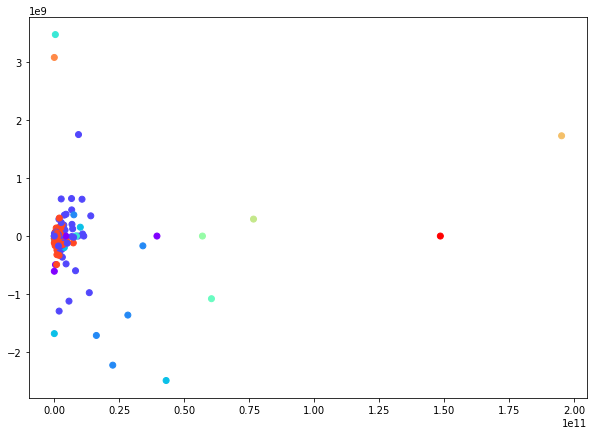

In [283]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp12[:,0], hcbp12[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2013 before PCA

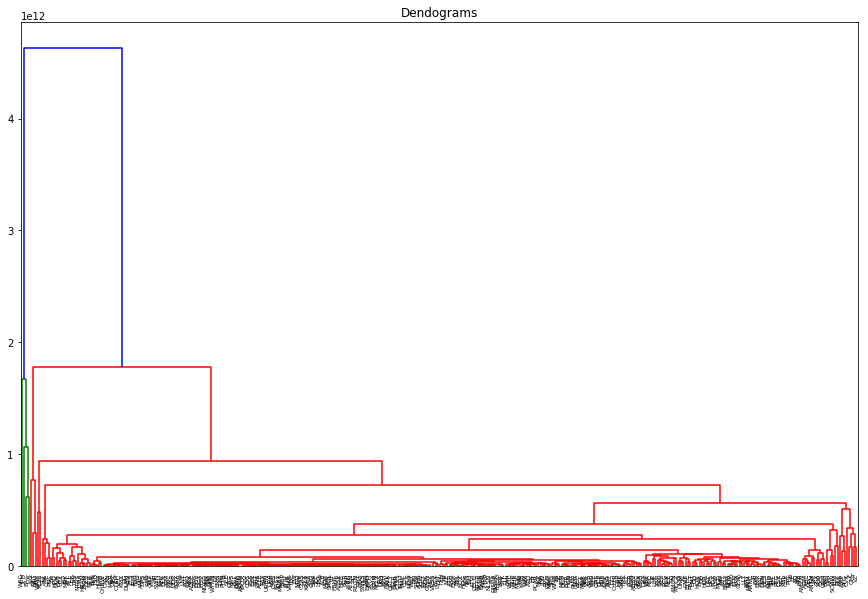

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC',

In [284]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp13 = data2013.iloc[:,0:83].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcbp13, method='complete')#ward)
labels=names2013
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2013,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [285]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp13) 

array([11, 11,  3, 11,  8,  3,  8,  8,  8, 11,  1, 10,  8,  8,  8,  8,  8,
        8,  1,  8,  8,  8,  8, 11,  1,  8,  3,  8,  3, 11, 11, 11,  8,  8,
       11,  8,  8,  8,  1,  3,  0, 11,  1,  8,  8, 11,  8,  6,  8, 11,  8,
        8,  8,  0,  3,  1,  8,  8,  8,  8,  8, 11,  8,  8, 11,  8,  8,  1,
       11,  8,  8,  8,  8,  8,  6,  8,  8,  8,  8, 11,  8, 11,  8,  8,  3,
        4,  8, 11, 11, 11, 11,  1,  8,  8,  8, 11,  8,  8,  8,  8,  8,  8,
        8, 11,  8, 11, 11,  8, 11,  8, 11,  8, 11, 11,  8,  8,  8, 11,  8,
       11, 11, 11,  8, 11,  8,  8,  8,  4,  8,  8,  8, 11, 11, 11,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8, 11,  8,  8, 11,  4,  8,  8,  8,  8,
       11,  1, 11,  8,  8, 11,  1,  8, 11,  8,  3,  8,  8,  8,  8,  8,  3,
        8,  8,  8, 11,  8,  8,  8,  8,  8,  8,  8,  8,  7,  8,  8,  8, 11,
        8,  3,  8,  8,  8,  8,  8, 11, 11,  8, 11, 11,  8,  8,  8,  8,  8,
        8,  8,  8,  8, 11,  8, 11,  5,  8,  8,  8,  8, 11,  8, 11,  8,  3,
        3, 11,  1,  8,  8

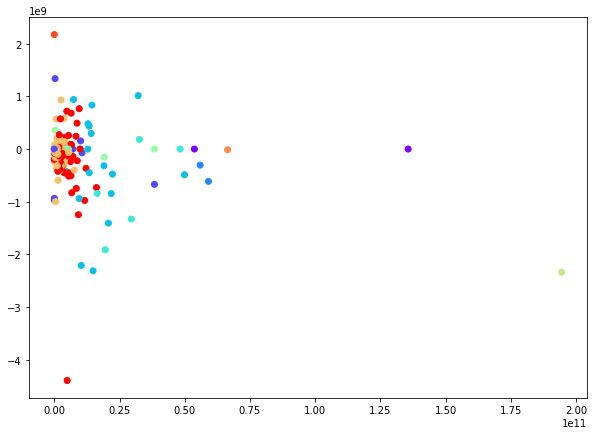

In [286]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp13[:,0], hcbp13[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2014 before PCA

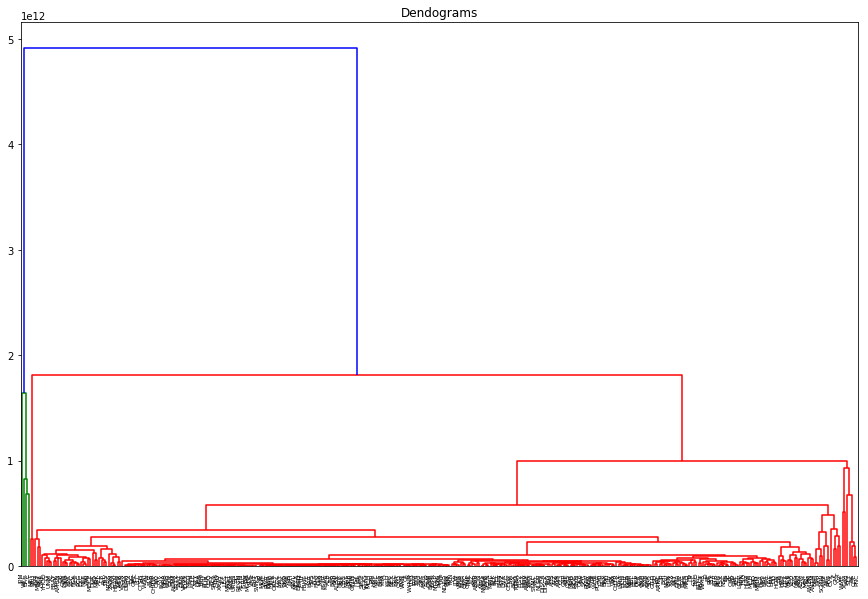

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'F

In [287]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp14 = data2014.iloc[:,0:83].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcbp14, method='complete')#ward)
labels=names2014
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2014,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [288]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp14) 

array([ 0,  0,  0,  0,  5,  0,  5,  5,  5,  0,  4, 10,  5,  5,  5,  5,  5,
        5,  4,  5,  5,  5,  5,  0,  4,  5,  0,  5,  0,  0,  0,  0,  5,  5,
        0,  5,  5,  5,  4,  0, 11,  5,  4,  5,  5,  0,  5,  7,  5,  0,  5,
        5,  5,  6,  0,  0,  4,  5,  5,  5,  5,  5,  0,  5,  5,  0,  5,  5,
        5,  4,  0,  5,  5,  5,  5,  5,  7,  5,  5,  5,  5,  0,  0,  5,  5,
        0,  2,  5,  0,  0,  0,  0,  4,  5,  5,  5,  0,  5,  5,  5,  5,  5,
        5,  5,  0,  5,  0,  5,  0,  5,  0,  5,  0,  5,  5,  5,  0,  5,  5,
        5,  5,  5,  0,  0,  0,  5,  0,  5,  5,  5,  2,  5,  0,  5,  0,  0,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  5,  0,  5,  2,  5,  5,
        5,  0,  5,  4,  0,  5,  5,  0,  2,  5,  0,  5,  0,  5,  5,  5,  5,
        0,  0,  5,  5,  5,  0,  5,  5,  5,  5,  5,  5,  5,  5,  9,  5,  5,
        5,  5,  0,  5,  0,  5,  5,  5,  5,  5,  0,  0,  5,  0,  0,  5,  5,
        0,  5,  5,  5,  5,  5,  5,  0,  5,  0,  5,  0,  3,  5,  5,  5,  5,
        0,  5,  0,  5,  0

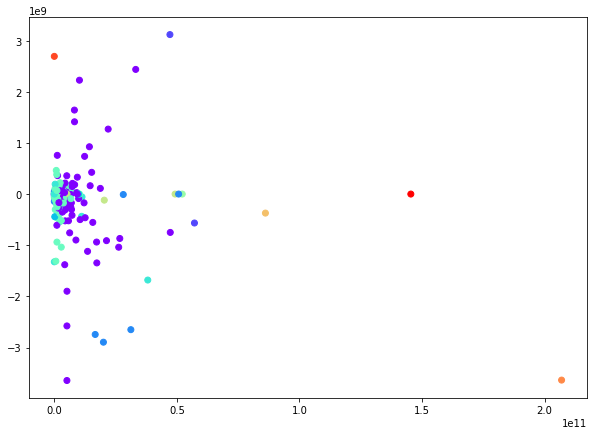

In [289]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp14[:,0], hcbp14[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2015 before PCA

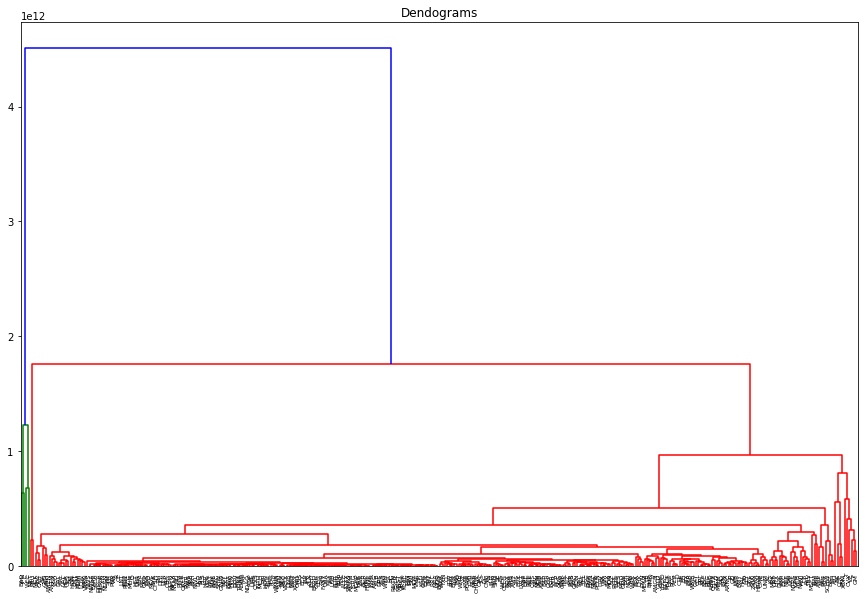

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'AYI', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CCL', 'CELG', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC', 'F

In [290]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp15 = data2015.iloc[:,0:83].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcbp15, method='complete')#ward)
labels=names2015
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2015,
           leaf_rotation=90,
           leaf_font_size=6)

plt.show()

print(labels)

In [291]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp15) 

array([ 1,  1,  3,  1,  1,  3,  1,  1,  1,  0,  9,  1,  1,  1,  1,  1,  1,
        0,  1,  1,  1,  1,  1,  0,  1,  3,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  1,  3, 11,  1,  0,  1,  1,  1,  1,  5,  1,  1,  1,
        1,  1,  8,  3,  3,  0,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  3,
        2,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,
        1,  0,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  3,  3,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  1,  1,  1,  3,  3,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  1,  1,  7,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  3,  3,  1

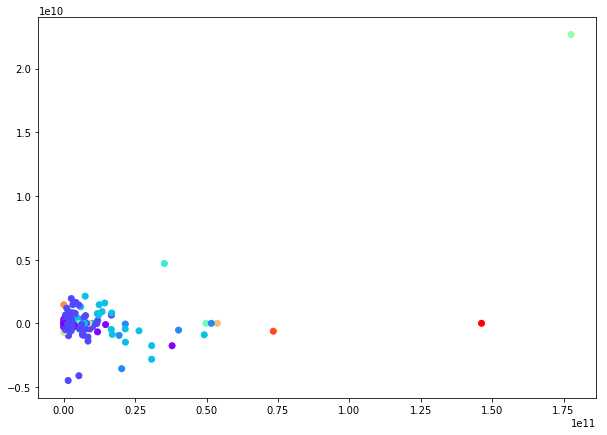

In [292]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp15[:,0], hcbp15[:,1], c=cluster.labels_, cmap='rainbow') 

### HC for 2016 before PCA

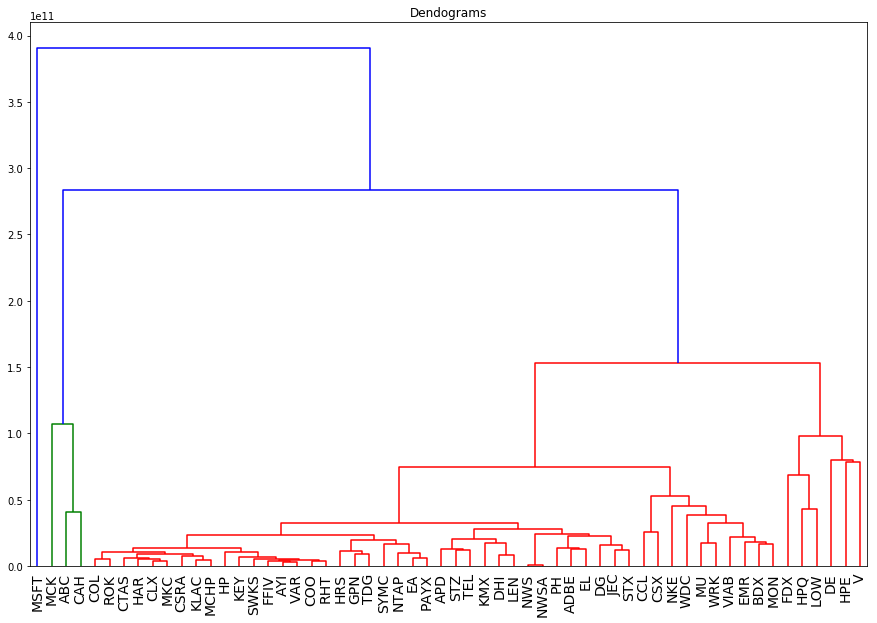

['ABC', 'ADBE', 'APD', 'AYI', 'BDX', 'CAH', 'CCL', 'CLX', 'COL', 'COO', 'CSRA', 'CSX', 'CTAS', 'DE', 'DG', 'DHI', 'EA', 'EL', 'EMR', 'FDX', 'FFIV', 'GPN', 'HAR', 'HP', 'HPE', 'HPQ', 'HRS', 'JEC', 'KEY', 'KLAC', 'KMX', 'LEN', 'LOW', 'MCHP', 'MCK', 'MKC', 'MON', 'MSFT', 'MU', 'NKE', 'NTAP', 'NWS', 'NWSA', 'PAYX', 'PH', 'RHT', 'ROK', 'STX', 'STZ', 'SWKS', 'SYMC', 'TDG', 'TEL', 'V', 'VAR', 'VIAB', 'WDC', 'WRK']


In [278]:
import matplotlib.pyplot as plt  
%matplotlib inline
hcbp16 = data2016.iloc[:,0:83].values

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcbp16, method='complete')#ward)
labels=names2016
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=names2016,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [280]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcbp16) 

array([ 1,  3,  3, 10,  0,  1,  4, 10, 10, 10, 10,  4, 10,  7,  3,  3, 10,
        3,  0, 11, 10,  3, 10, 10,  8,  2,  3,  3, 10, 10,  3,  3,  2, 10,
        6, 10,  0,  5,  0,  0, 10,  3,  3, 10,  3, 10, 10,  3,  3, 10,  3,
        3,  3,  9, 10,  0,  0,  0])

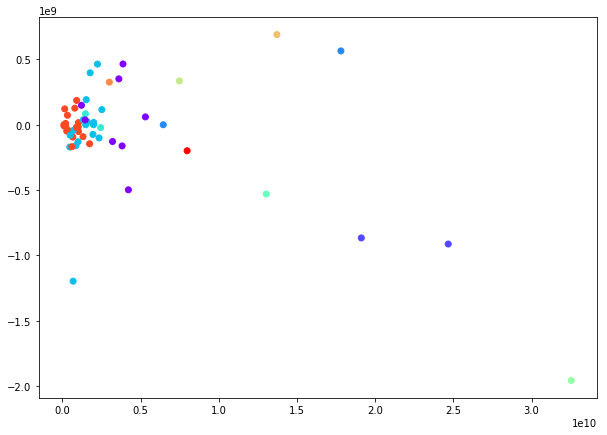

In [281]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcbp16[:,0], hcbp16[:,1], c=cluster.labels_, cmap='rainbow')  

## Hierarchical Clustering after PCA

### HC for 2012 after PCA

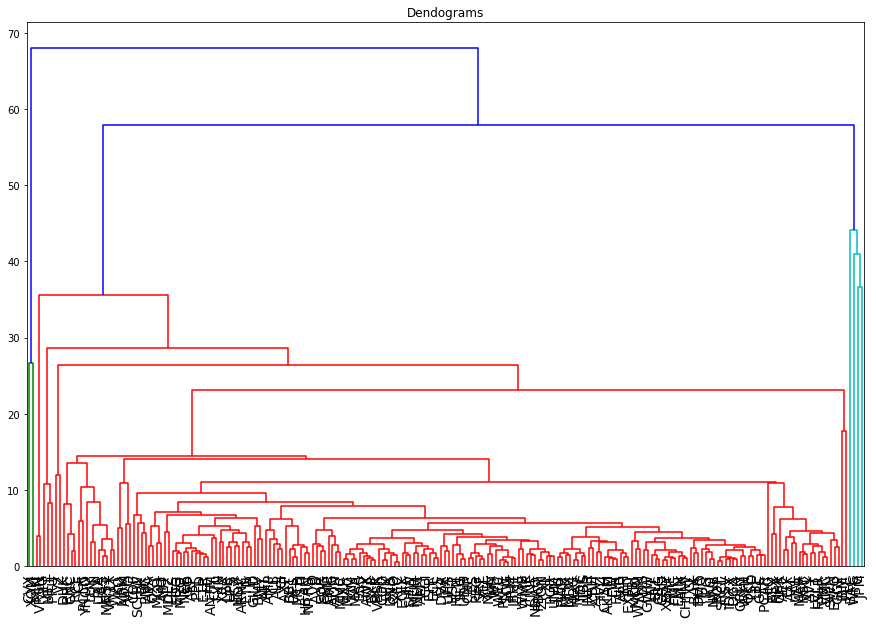

['AAL', 'ABT', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AKAM', 'ALB', 'ALK', 'ALL', 'AME', 'AMG', 'AMP', 'AMT', 'ANTM', 'AON', 'APA', 'APH', 'ARNC', 'ATVI', 'AVB', 'AVY', 'AWK', 'AXP', 'BAC', 'BAX', 'BBT', 'BK', 'BLL', 'BMY', 'BSX', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CF', 'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CME', 'CNC', 'CNP', 'COF', 'COG', 'CTL', 'CTSH', 'CVX', 'CXO', 'D', 'DFS', 'DGX', 'DHR', 'DLR', 'DNB', 'DUK', 'DVA', 'ECL', 'EFX', 'EIX', 'EMN', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXPD', 'EXR', 'FCX', 'FE', 'FIS', 'FISV', 'FLIR', 'FMC', 'FSLR', 'FTR', 'GGP', 'GILD', 'GPC', 'GWW', 'HAS', 'HBAN', 'HCN', 'HES', 'HIG', 'HOG', 'HST', 'HSY', 'IBM', 'IDXX', 'IFF', 'IP', 'IPG', 'IRM', 'IVZ', 'JBHT', 'JNPR', 'JPM', 'KIM', 'KO', 'LEG', 'LH', 'LKQ', 'LLL', 'LLY', 'LNT', 'LUK', 'LVLT', 'LYB', 'MAA', 'MAC', 'MAR', 'MAT', 'MCD', 'MCO', 'MDLZ', 'MET', 'MHK', 'MJN', 'MLM', 'MMC', 'MNST', 'MO', 'MRK', 'MRO', 'MTB', 'MUR', 'NDAQ', 'NEE', 'NEM', 'NFX', 'NOV',

In [305]:
hcap12 = pca2012.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcap12, method='complete')#ward)
labels=pcaname2012
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2012,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [306]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap12) 

array([ 0,  2,  2,  0,  0,  2,  2,  6,  0,  0,  0,  0,  2,  0,  0,  2,  0,
        2,  0,  2,  0,  2,  0,  0,  0,  0,  2, 11,  2,  2,  2,  0,  2,  0,
        0,  8,  2,  0,  0,  0,  0,  0,  0,  2,  0,  2,  0,  0,  2,  2,  0,
        2,  0, 10,  0,  2,  2,  0,  2,  0,  0,  2,  0,  0,  0,  0,  0,  2,
        0,  0,  2,  0,  0,  2,  2,  0,  0,  0,  2,  2,  0,  0,  0,  0,  0,
        0,  0,  2,  0,  0,  0,  2,  0,  2,  2,  0,  0,  0,  5,  0,  0,  2,
        0,  0,  0,  0,  0,  7,  0,  5,  0,  0,  0,  0,  2,  0,  0,  0,  2,
        0,  0,  0,  0,  2,  0,  2,  6,  0,  4,  0,  0,  0,  2,  5,  2,  2,
        2,  0,  2,  2,  0,  2,  2,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        2,  5,  0,  2,  0,  0,  2,  6,  0,  0,  0,  0,  0,  0,  2,  0,  0,
        0,  0,  2,  0,  0,  2,  2,  0,  1,  0,  0,  0,  0,  0,  2,  0,  0,
        0,  0,  0,  2,  0,  2,  0,  0,  4,  0,  1,  0,  0,  3,  0,  0,  0,
        0,  0,  0,  2,  0,  9,  0,  2,  0,  0,  0])

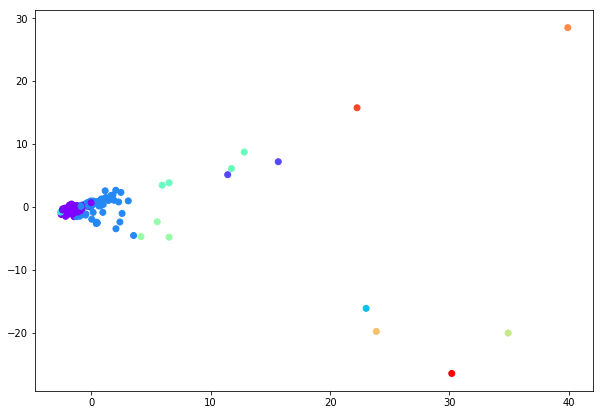

In [307]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap12[:,0], hcap12[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2013 after PCA

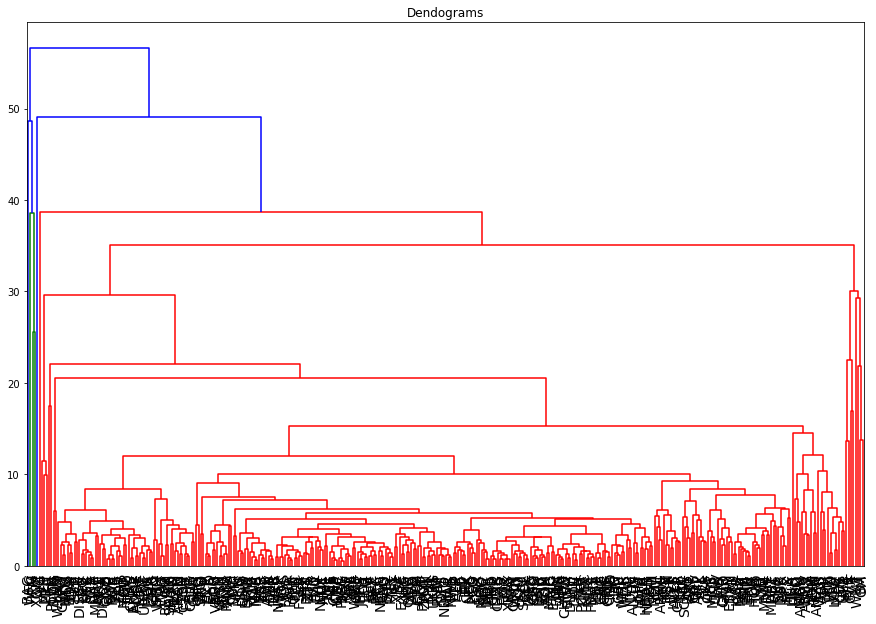

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC',

In [308]:
hcap13 = pca2013.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcap13, method='complete')#ward)
labels=pcaname2013
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2013,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [309]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap13) 

array([ 1,  4,  4,  4,  8,  4,  8,  8,  1,  1,  1,  5,  1,  1,  1,  8,  1,
        1,  1,  1,  8,  1,  1,  4,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,
        1,  4,  1,  1,  1,  3,  9,  4,  1,  8,  8,  4,  8,  1,  1,  4,  1,
        1,  1,  2,  4,  1,  1,  1,  8,  8,  1,  1,  1,  1,  1,  1,  4,  1,
        4,  8,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  1,  4,
        0,  1,  1,  4,  4,  4,  1,  1,  1,  4,  4,  4,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  4,  1,  1,  1,  8,  1,  1,
        1,  4,  1,  8,  1,  1,  1,  1, 11,  8,  8,  1,  4,  4,  1,  1,  1,
        1,  8,  1,  1,  1,  1,  1,  1,  4,  1,  4,  8,  3,  1,  1,  4,  8,
        4,  1,  4,  1,  1,  4,  1,  1,  4,  8,  3,  1,  1,  1,  1,  1,  3,
        1,  1,  1,  4,  4,  1,  8,  4,  4,  1,  1,  1,  2,  1,  1,  4,  1,
        1,  3,  1,  1,  1,  1,  1,  4,  4,  1,  4,  4,  1,  1,  4,  4,  1,
        1,  1,  1,  1,  4,  8,  1,  5,  1,  1,  1,  1,  4,  1,  4,  8,  4,
        3,  1,  1,  8,  1

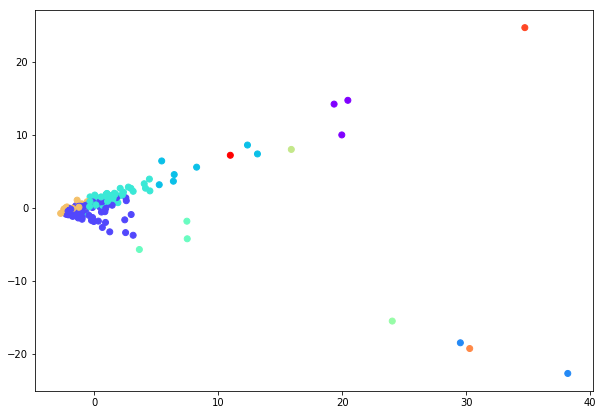

In [310]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap13[:,0], hcap13[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2014 after PCA

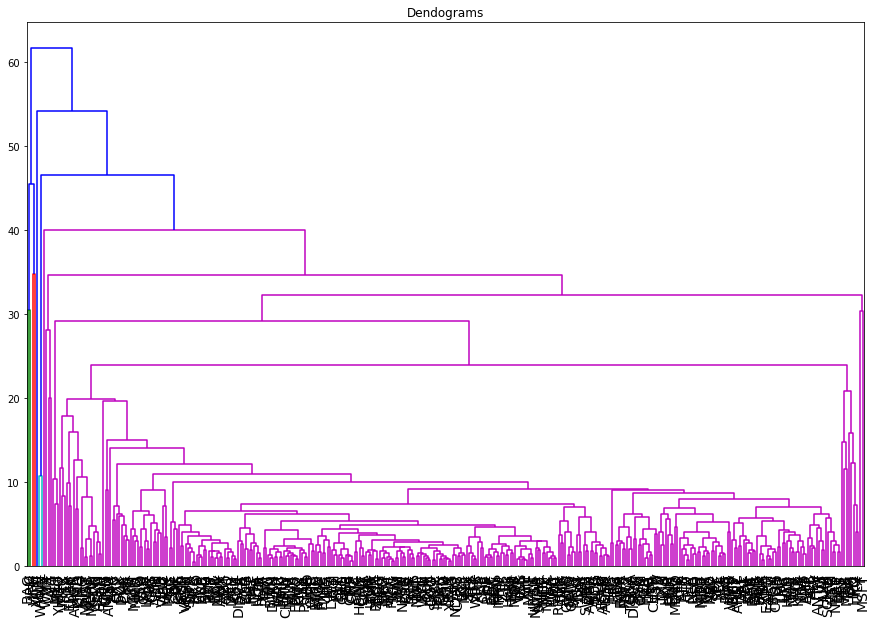

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'ADSK', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CELG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COO', 'CRM', 'CSX', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'F

In [311]:
hcap14 = pca2014.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcap14, method='complete')#ward)
labels=pcaname2014
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2014,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [312]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap14) 

array([ 2,  2,  2,  2, 10,  2, 10, 10, 10,  2,  2,  6, 10, 10, 10, 10, 10,
       10,  2,  5,  3, 10, 10,  3,  2, 10,  2, 10,  2, 10,  2,  2, 10, 10,
        2, 10, 10, 10,  2,  0,  1,  2, 10, 10, 10,  2,  3,  2, 10,  2, 10,
       10, 10,  1,  2,  2,  2, 10, 10,  3,  3, 10,  2, 10, 10,  2, 10,  2,
       10, 10, 10,  3, 10, 10, 10, 10,  2, 10, 10, 10, 10,  2,  2, 10, 10,
        2,  4, 10,  2,  2,  2,  2, 10, 10, 10, 10,  2, 10, 10, 10, 10, 10,
       10, 10,  2, 10,  2,  2,  2, 10,  2, 10,  2, 10, 10,  2,  2, 10, 10,
       10,  2, 10, 10,  2,  2,  3,  2, 10, 10, 10,  0, 10,  3, 10,  2,  2,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  2, 10,  3,  3,  0, 10, 10,
       10,  2, 10, 10,  2, 10, 10,  2,  2, 10,  2, 10,  0, 10, 10, 10, 10,
        2,  0, 10, 10, 10, 10, 10, 10,  3, 10, 10, 10, 10, 10,  9, 10, 10,
        3,  2,  2, 10,  0, 10, 10, 10, 10, 10,  2,  2, 10,  2,  2, 10, 10,
        2,  2, 10, 10, 10, 10, 10,  2,  3,  2, 10,  2,  6, 10, 10, 10, 10,
        2,  3,  2, 10,  2

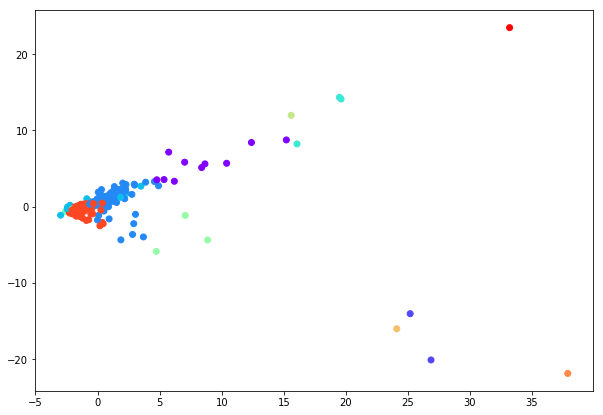

In [313]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap14[:,0], hcap14[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2015 after PCA

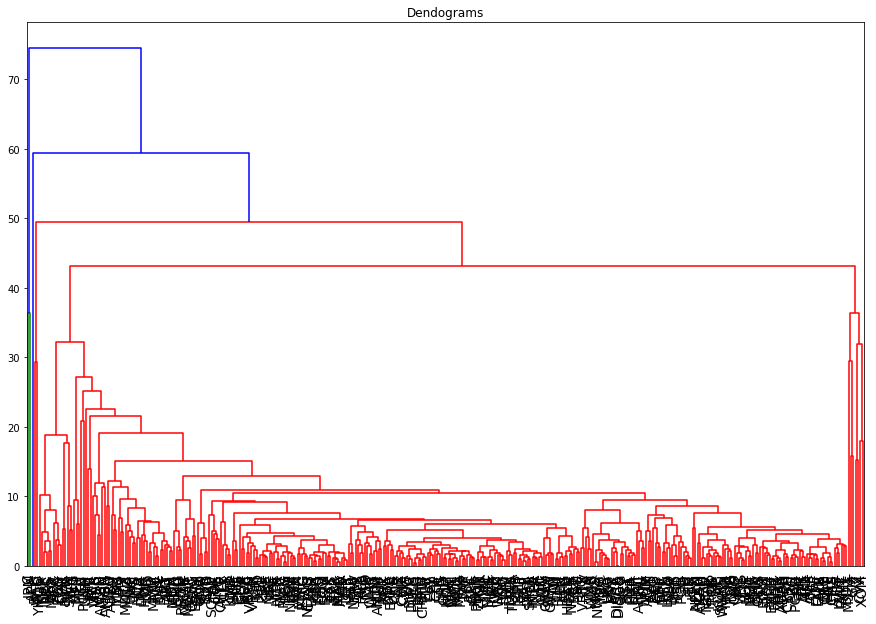

['AAL', 'ABBV', 'ABC', 'ABT', 'ADBE', 'ADM', 'ADS', 'AEE', 'AEP', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB', 'AWK', 'AXP', 'AYI', 'BA', 'BAC', 'BAX', 'BBT', 'BCR', 'BDX', 'BHI', 'BIIB', 'BK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAH', 'CAT', 'CB', 'CBG', 'CCI', 'CCL', 'CELG', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DNB', 'DOV', 'DPS', 'DUK', 'DVA', 'DVN', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FAST', 'FB', 'FBHS', 'FCX', 'FE', 'FFIV', 'FIS', 'FISV', 'FLIR', 'FLR', 'FLS', 'FMC', 'F

In [314]:
hcap15 = pca2015.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcap15, method='complete')#ward)
labels=pcaname2015
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2015,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [315]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap15) 

array([ 8,  8,  8,  8,  4,  8,  4,  4,  4,  4,  7,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  8,  4,  4,  8,  4,  8,  4,  6,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  8,  1,  4,  4,  4,  4,  4,  4,  4,  4,  8,  4,
        4,  4,  9,  8,  8,  4,  4,  4,  4,  5,  4,  4,  4,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  8,
        2,  4,  4,  8,  8,  4,  4,  4,  4,  8,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  3,  4,  8,  4,  4,  4,  4,  4,  4,  8,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  4,  5,  4,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  5,  8,  4,  8,  4,  0,  4,  4,  4,  4,
        4,  4,  8,  4,  4,  3,  4,  4,  8,  4,  4,  4,  4,  4,  0,  4,  4,
        4,  4,  4,  4,  4,  4,  8,  4,  4,  4, 11,  4,  4,  4,  4,  4,  0,
        4,  4,  4,  4,  4,  4,  8,  8,  4,  8,  8,  4,  4,  8,  8,  4,  4,
        4,  4,  4,  8,  5,  8,  4,  8,  7,  4,  4,  4,  4,  4,  8,  5,  8,
        8,  4,  8,  0,  3

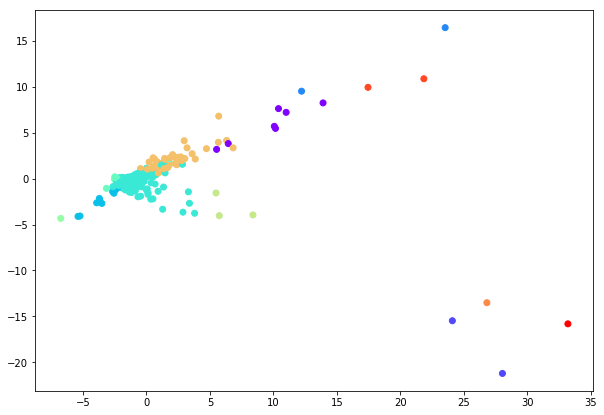

In [316]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap15[:,0], hcap15[:,1], c=cluster.labels_, cmap='rainbow')  

### HC for 2016 after PCA

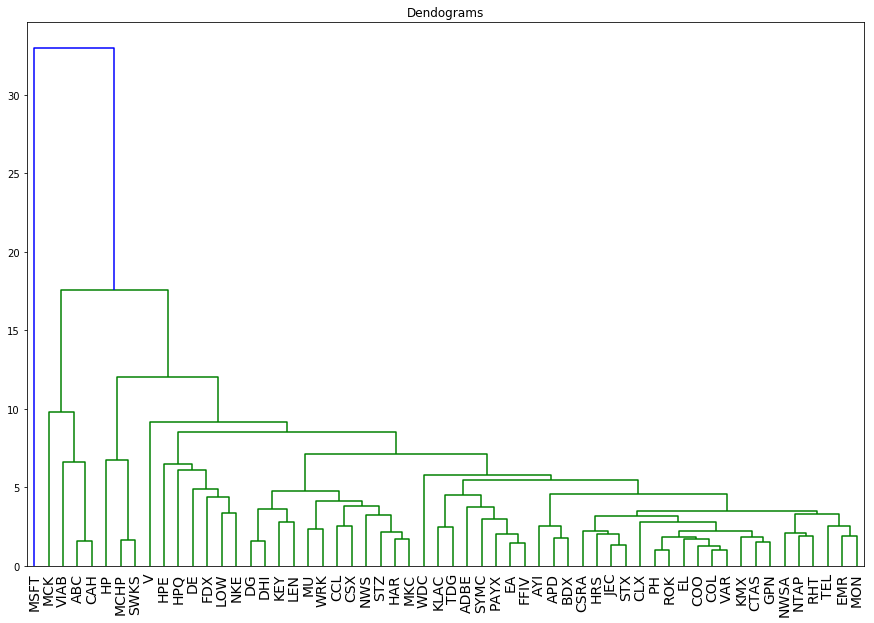

['ABC', 'ADBE', 'APD', 'AYI', 'BDX', 'CAH', 'CCL', 'CLX', 'COL', 'COO', 'CSRA', 'CSX', 'CTAS', 'DE', 'DG', 'DHI', 'EA', 'EL', 'EMR', 'FDX', 'FFIV', 'GPN', 'HAR', 'HP', 'HPE', 'HPQ', 'HRS', 'JEC', 'KEY', 'KLAC', 'KMX', 'LEN', 'LOW', 'MCHP', 'MCK', 'MKC', 'MON', 'MSFT', 'MU', 'NKE', 'NTAP', 'NWS', 'NWSA', 'PAYX', 'PH', 'RHT', 'ROK', 'STX', 'STZ', 'SWKS', 'SYMC', 'TDG', 'TEL', 'V', 'VAR', 'VIAB', 'WDC', 'WRK']


In [317]:
hcap16 = pca2016.iloc[:,0:20].values

plt.figure(figsize=(15, 10))  
plt.title("Dendograms")
mergings = linkage(hcap16, method='complete')#ward)
labels=pcaname2016
#labels = fcluster(mergings, 70, criterion='distance')
dendrogram(mergings,
           labels=pcaname2016,
           leaf_rotation=90,
           leaf_font_size=14)

plt.show()

print(labels)

In [318]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                  linkage='ward')  
cluster.fit_predict(hcap16) 

array([ 3,  5,  0,  0,  0,  3,  2,  0,  0,  0,  0,  2,  0,  1,  0,  0,  5,
        0,  0,  1,  5,  0,  2, 10, 11,  1,  0,  0,  2,  5,  0,  2,  1,  4,
        6,  2,  0,  7,  2,  1,  0,  2,  0,  5,  0,  0,  0,  0,  2,  4,  5,
        5,  0,  8,  0,  9,  0,  2])

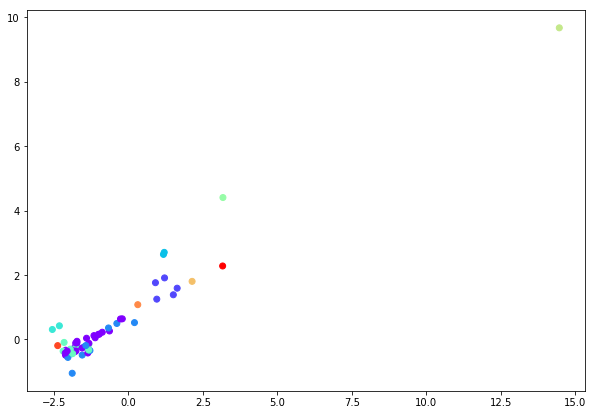

In [319]:
plt.figure(figsize=(10, 7))  
plt.scatter(hcap16[:,0], hcap16[:,1], c=cluster.labels_, cmap='rainbow')  

-------------------

### Classification Models

In [ ]:
#try some classification techniques

In [ ]:
X=new_data2.iloc[:,0:84]
y=new_data2.trend

In [ ]:
SEED=1
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
def first_classifier(model):
    classifier = model()
    classifier.fit(X_train,y_train)
    print(classifier.score(X_test,y_test))
    #y_pred=classifier.predict(X_test)
    #print(metrics.accuracy_score(y_test, y_pred))
    return classifier

In [ ]:
mod_logreg = first_classifier(LogisticRegression)
acc_log_reg = round( mod_logreg.score(X_test, y_test) * 100, 2)
mod_svc = first_classifier(SVC)
acc_svc = round( mod_svc.score(X_test, y_test) * 100, 2)

mod_linear_svc =first_classifier(LinearSVC)
acc_linear_svc = round( mod_linear_svc.score(X_test, y_test) * 100, 2)

mod_knn =first_classifier(KNN)
acc_knn = round( mod_knn.score(X_test, y_test) * 100, 2)

mod_decision_tree =first_classifier(DecisionTreeClassifier)
acc_decision_tree = round( mod_decision_tree.score(X_test, y_test) * 100, 2)

mod_random_forest=first_classifier(RandomForestClassifier)
acc_random_forest = round( mod_random_forest.score(X_test, y_test) * 100, 2)


In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 
              'KNN', 'Decision Tree', 'Random Forest'],
    
    'Score': [acc_log_reg, acc_svc, acc_linear_svc, 
              acc_knn,  acc_decision_tree, acc_random_forest]
    })

models.sort_values(by='Score', ascending=False)

In [ ]:
#new_data3=new_data2[['symbol','date', 'After Tax ROE','Current Ratio','Earnings Before Interest and Tax','Earnings Before Tax','Gross Profit','Net Cash Flow','Net Income','Profit Margin','Quick Ratio','Total Assets','Total Equity','Total Liabilities','Total Liabilities & Equity','Total Revenue','For Year', 'Earnings Per Share','open', 'close', 'low', 'high', 'volume', 'Security', 'GICS Sector',
       #'GICS Sub Industry', 'PE']]